In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline
plt.style.use('default')

import functools
import warnings
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter
from scipy.optimize import curve_fit

import uncertainty_toolbox as uct
import sklearn
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [3]:
def flatten(func):
    ''' Decorator to flatten function parameters '''
    @functools.wraps(func)
    def helper(*args, **kwargs):
        flat_args = [a if a is None else a.flatten() for a in args]
        return func(*flat_args, **kwargs)
    return helper

def validate_shape(func):
	''' Decorator to flatten all function input arrays, and ensure shapes are the same '''
	@functools.wraps(func)
	def helper(*args, **kwargs):
		flat     = [a.flatten() if hasattr(a, 'flatten') else a for a in args]
		flat_shp = [a.shape for a in flat if hasattr(a, 'shape')]
		orig_shp = [a.shape for a in args if hasattr(a, 'shape')]
		assert(all(flat_shp[0] == s for s in flat_shp)), f'Shapes mismatch in {func.__name__}: {orig_shp}'
		return func(*flat, **kwargs)
	return helper

def only_finite(func):
	''' Decorator to remove samples which are nan in any input array '''
	@validate_shape
	@functools.wraps(func)
	def helper(*args, **kwargs):
		stacked = np.vstack(args)
		valid   = np.all(np.isfinite(stacked), 0)
		assert(valid.sum()), f'No valid samples exist for {func.__name__} metric'
		return func(*stacked[:, valid], **kwargs)
	return helper

def only_valid(func):
    ''' Decorator to remove all elements having a nan in any array '''
    @functools.wraps(func)
    def helper(*args, **kwargs):
        assert(all([len(a.shape) == 1 for a in args]))
        stacked = np.vstack(args)
        valid = np.all(np.isfinite(stacked), 0)
        return func(*stacked[:, valid], **kwargs)
    return helper

def only_positive(func):
	''' Decorator to remove samples which are zero/negative in any input array '''
	@validate_shape
	@functools.wraps(func)
	def helper(*args, **kwargs):
		stacked = np.vstack(args)
		valid   = np.all(stacked > 0, 0)
		assert(valid.sum()), f'No valid samples exist for {func.__name__} metric'
		return func(*stacked[:, valid], **kwargs)
	return helper


def label(name):
    ''' Label a function for when it's printed '''
    def helper(f):
        f.__name__ = name
        return f
    return helper

@only_finite
@label('RMSE')
def rmse(y, y_hat):
	''' Root Mean Squared Error '''
	return np.mean((y - y_hat) ** 2) ** .5


@only_finite
@only_positive
@label('RMSLE')
def rmsle(y, y_hat):
	''' Root Mean Squared Logarithmic Error '''
	return np.mean(np.abs(np.log(y) - np.log(y_hat)) ** 2) ** 0.5


@only_finite
@label('NRMSE')
def nrmse(y, y_hat):
	''' Normalized Root Mean Squared Error '''
	return ((y - y_hat) ** 2).mean() ** .5 / y.mean()

@only_finite
@only_positive
@label('R^2')
def r_squared(y, y_hat):
	''' Logarithmic R^2 '''
	slope_, intercept_, r_value, p_value, std_err = stats.linregress(np.log10(y), np.log10(y_hat))
	return r_value**2

@label('<=0')
@flatten
@only_valid
def leqz(y1, y2=None):
    ''' Less than or equal to zero (y2) '''
    if y2 is None: y2 = y1
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        return (y2 <= 0).sum()


@label('<=0|NaN')
@flatten
def leqznan(y1, y2=None):
    ''' Less than or equal to zero (y2) '''
    if y2 is None: y2 = y1
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        return np.logical_or(np.isnan(y2), y2 <= 0).sum()

@label('MAD')
@flatten
@only_valid
def MAD(y1, y2):
    ''' Mean Absolute Error '''
    i  = np.logical_and(y1 > 0, y2 > 0)
    y1 = np.log10(y1[i])
    y2 = np.log10(y2[i])
    i  = np.logical_and(np.isfinite(y1), np.isfinite(y2))
    y1 = y1[i]
    y2 = y2[i]
    return 10**np.mean(np.abs(y1 - y2))-1

@only_finite
@label('MdAPE')
def mape(y, y_hat):
	''' Mean Absolute Percentage Error '''
	return 100 * np.mean(np.abs((y - y_hat) / y))

@only_finite
@only_positive
@label('MSA')
def msa(y, y_hat):
	''' Mean Symmetric Accuracy '''
	# https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017SW001669
	return 100 * (np.exp(np.mean(np.abs(np.log(y_hat / y)))) - 1)


@only_finite
@only_positive
@label('MdSA')
def mdsa(y, y_hat):
	''' Median Symmetric Accuracy '''
	# https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017SW001669
	return 100 * (np.exp(np.median(np.abs(np.log(y_hat / y)))) - 1)

@only_finite
@only_positive
@label('SSPB')
def sspb(y, y_hat):
	''' Symmetric Signed Percentage Bias '''
	# https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017SW001669
	M = np.median( np.log(y_hat / y) )
	return 100 * np.sign(M) * (np.exp(np.abs(M)) - 1)


@only_finite
@label('Bias')
def bias(y, y_hat):
	''' Mean Bias '''
	return np.mean(y_hat - y)

@only_finite
@only_positive
@label('Slope')
def slope(y, y_hat):
	''' Logarithmic slope '''
	slope_, intercept_, r_value, p_value, std_err = stats.linregress(np.log10(y), np.log10(y_hat))
	return slope_


@only_finite
@only_positive
@label('Intercept')
def intercept(y, y_hat):
	''' Locarithmic intercept '''
	slope_, intercept_, r_value, p_value, std_err = stats.linregress(np.log10(y), np.log10(y_hat))
	return intercept_

@validate_shape
@label('MWR')
def mwr(y, y_hat, y_bench):
	'''
	Model Win Rate - Percent of samples in which model has a closer
	estimate than the benchmark.
		y: true, y_hat: model, y_bench: benchmark
	'''
	y_bench[y_bench < 0] = np.nan
	y_hat[y_hat < 0] = np.nan
	y[y < 0] = np.nan
	valid = np.logical_and(np.isfinite(y_hat), np.isfinite(y_bench))
	diff1 = np.abs(y[valid] - y_hat[valid])
	diff2 = np.abs(y[valid] - y_bench[valid])
	stats = np.zeros(len(y))
	stats[valid]  = diff1 < diff2
	stats[~np.isfinite(y_bench)] = 1
	stats[~np.isfinite(y_hat)] = 0
	return stats.sum() / np.isfinite(y).sum()

def performance(key, y1, y2, metrics=[rmse, slope, msa, rmsle, sspb, MAD, leqznan]):#[rmse, rmsle, mape, r_squared, bias, mae, leqznan, slope]):
    ''' Return a string containing performance using various metrics.
        y1 should be the true value, y2 the estimated value. '''
    return '%8s | %s' % (key, '   '.join([
            '%s: %6.3f' % (f.__name__, f(y1,y2)) for f in metrics]))

In [4]:
# Load data

## Load data

In [5]:
# Overall und Case 1
gloria_res_prisma_s = pd.read_csv('C:/SwitchDrive/Data/prisma_dataset_formatting/case_1_insitu_vs_insitu/gloria_res_prisma_s.csv')
prisma_insitu = pd.read_csv('C:/SwitchDrive/Data/prisma_dataset_formatting//case_1_insitu_vs_insitu/prisma_insitu.csv')

In [6]:
# Case 2
prisma_aco = pd.read_csv('C:/SwitchDrive/Data/prisma_dataset_formatting/case_2_insitu_vs_aco/prisma_aco.csv')
prisma_l2 = pd.read_csv('C:/SwitchDrive/Data/prisma_dataset_formatting/case_2_insitu_vs_l2/prisma_l2.csv')


In [7]:
# Case 3
combined_local_train_df = pd.read_csv('C:/SwitchDrive/Data/prisma_dataset_formatting/case_3_local_insitu_vs_aco/combined_local_train_df.csv')


# Case 1 processing

In [8]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.preprocessing import RobustScaler

# Select Rrs values in 5 nm steps and target variables
c1_rrs_columns_train = ['406_prisma_res', '415_prisma_res',
       '423_prisma_res', '431_prisma_res', '438_prisma_res',
       '446_prisma_res', '453_prisma_res', '460_prisma_res',
       '468_prisma_res', '475_prisma_res', '482_prisma_res',
       '489_prisma_res', '497_prisma_res', '504_prisma_res',
       '512_prisma_res', '519_prisma_res', '527_prisma_res',
       '535_prisma_res', '542_prisma_res', '550_prisma_res',
       '559_prisma_res', '567_prisma_res', '575_prisma_res',
       '583_prisma_res', '592_prisma_res', '601_prisma_res',
       '609_prisma_res', '618_prisma_res', '627_prisma_res',
       '636_prisma_res', '645_prisma_res', '655_prisma_res',
       '664_prisma_res', '674_prisma_res', '684_prisma_res',
       '694_prisma_res']

c1_y_columns_train = ['aph_443', 'aph_675','aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675']

# Extract features and target variables
c1_X_train = gloria_res_prisma_s[c1_rrs_columns_train].values
c1_y_train = gloria_res_prisma_s[c1_y_columns_train].values

# scale train input
c1_scaler_x = RobustScaler()
c1_X_train_scaled = c1_scaler_x.fit_transform(c1_X_train)

# Scale train output
c1_y_train_log = np.log(c1_y_train)
c1_scaler_y = MinMaxScaler(feature_range=(-1, 1))
c1_y_train_scaled = c1_scaler_y.fit_transform(c1_y_train_log)

### test

# Select Rrs values in 5 nm steps and target variables
c1_rrs_columns_test = ['406_prisma_insitu', '415_prisma_insitu', '423_prisma_insitu',
       '431_prisma_insitu', '438_prisma_insitu', '446_prisma_insitu',
       '453_prisma_insitu', '460_prisma_insitu', '468_prisma_insitu',
       '475_prisma_insitu', '482_prisma_insitu', '489_prisma_insitu',
       '497_prisma_insitu', '504_prisma_insitu', '512_prisma_insitu',
       '519_prisma_insitu', '527_prisma_insitu', '535_prisma_insitu',
       '542_prisma_insitu', '550_prisma_insitu', '559_prisma_insitu',
       '567_prisma_insitu', '575_prisma_insitu', '583_prisma_insitu',
       '592_prisma_insitu', '601_prisma_insitu', '609_prisma_insitu',
       '618_prisma_insitu', '627_prisma_insitu', '636_prisma_insitu',
       '645_prisma_insitu', '655_prisma_insitu', '664_prisma_insitu',
       '674_prisma_insitu', '684_prisma_insitu', '694_prisma_insitu']

c1_y_columns_test = ['aph_443', 'aph_675', 'acdom_443', 'acdom_675', 'anap_443', 'anap_675']

# Extract features and target variables
c1_X_test = prisma_insitu[c1_rrs_columns_test].values
c1_y_test = prisma_insitu[c1_y_columns_test].values

# scale test input
c1_X_test_scaled = c1_scaler_x.transform(c1_X_test)

# Scale test output
c1_y_test_log = np.log(c1_y_test)
c1_y_test_scaled = c1_scaler_y.transform(c1_y_test_log)

# Display the shapes of the datasets
print("Case 1 training set shape:", c1_X_train_scaled.shape, c1_y_train_scaled.shape)
print("Case 1 test set shape:", c1_X_test_scaled.shape, c1_y_test_scaled.shape)


Case 1 training set shape: (2285, 36) (2285, 6)
Case 1 test set shape: (61, 36) (61, 6)


## Case 2 ACO processing

In [9]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.preprocessing import RobustScaler

# Select Rrs values in 5 nm steps and target variables
c2_aco_rrs_columns_train = ['406_prisma_res', '415_prisma_res',
       '423_prisma_res', '431_prisma_res', '438_prisma_res',
       '446_prisma_res', '453_prisma_res', '460_prisma_res',
       '468_prisma_res', '475_prisma_res', '482_prisma_res',
       '489_prisma_res', '497_prisma_res', '504_prisma_res',
       '512_prisma_res', '519_prisma_res', '527_prisma_res',
       '535_prisma_res', '542_prisma_res', '550_prisma_res',
       '559_prisma_res', '567_prisma_res', '575_prisma_res',
       '583_prisma_res', '592_prisma_res', '601_prisma_res',
       '609_prisma_res', '618_prisma_res', '627_prisma_res',
       '636_prisma_res', '645_prisma_res', '655_prisma_res',
       '664_prisma_res', '674_prisma_res', '684_prisma_res',
       '694_prisma_res']

c2_aco_y_columns_train = ['aph_443', 'aph_675','aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675']

# Extract features and target variables
c2_aco_X_train = gloria_res_prisma_s[c2_aco_rrs_columns_train].values
c2_aco_y_train = gloria_res_prisma_s[c2_aco_y_columns_train].values

# scale train input
c2_aco_scaler_x = RobustScaler()
c2_aco_X_train_scaled = c2_aco_scaler_x.fit_transform(c2_aco_X_train)

# Scale train output
c2_aco_y_train_log = np.log(c2_aco_y_train)
c2_aco_scaler_y = MinMaxScaler(feature_range=(-1, 1))
c2_aco_y_train_scaled = c2_aco_scaler_y.fit_transform(c2_aco_y_train_log)

### test

# Select Rrs values in 5 nm steps and target variables
c2_aco_rrs_columns_test = ['aco_406', 'aco_415', 'aco_423', 'aco_431', 'aco_438', 'aco_446',
       'aco_453', 'aco_460', 'aco_468', 'aco_475', 'aco_482', 'aco_489',
       'aco_497', 'aco_504', 'aco_512', 'aco_519', 'aco_527', 'aco_535',
       'aco_542', 'aco_550', 'aco_559', 'aco_567', 'aco_575', 'aco_583',
       'aco_592', 'aco_601', 'aco_609', 'aco_618', 'aco_627', 'aco_636',
       'aco_645', 'aco_655', 'aco_664', 'aco_674', 'aco_684', 'aco_694']

c2_aco_y_columns_test = ['aph_443', 'aph_675', 'acdom_443', 'acdom_675', 'anap_443', 'anap_675']

# Extract features and target variables
c2_aco_X_test = prisma_aco[c2_aco_rrs_columns_test].values
c2_aco_y_test = prisma_aco[c2_aco_y_columns_test].values

# scale test input
c2_aco_X_test_scaled = c2_aco_scaler_x.transform(c2_aco_X_test)

# Scale test output
c2_aco_y_test_log = np.log(c2_aco_y_test)
c2_aco_y_test_scaled = c2_aco_scaler_y.transform(c2_aco_y_test_log)

# Display the shapes of the datasets
print("Training set shape:", c2_aco_X_train.shape, c2_aco_y_train_scaled.shape)
print("Test set shape:", c2_aco_X_test.shape,c2_aco_y_test_scaled.shape)


Training set shape: (2285, 36) (2285, 6)
Test set shape: (50, 36) (50, 6)


## C2 L2 processing

In [10]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.preprocessing import RobustScaler

# Select Rrs values in 5 nm steps and target variables
c2_l2_rrs_columns_train = ['406_prisma_res', '415_prisma_res',
       '423_prisma_res', '431_prisma_res', '438_prisma_res',
       '446_prisma_res', '453_prisma_res', '460_prisma_res',
       '468_prisma_res', '475_prisma_res', '482_prisma_res',
       '489_prisma_res', '497_prisma_res', '504_prisma_res',
       '512_prisma_res', '519_prisma_res', '527_prisma_res',
       '535_prisma_res', '542_prisma_res', '550_prisma_res',
       '559_prisma_res', '567_prisma_res', '575_prisma_res',
       '583_prisma_res', '592_prisma_res', '601_prisma_res',
       '609_prisma_res', '618_prisma_res', '627_prisma_res',
       '636_prisma_res', '645_prisma_res', '655_prisma_res',
       '664_prisma_res', '674_prisma_res', '684_prisma_res',
       '694_prisma_res']

c2_l2_y_columns_train = ['aph_443', 'aph_675','aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675']

# Extract features and target variables
c2_l2_X_train = gloria_res_prisma_s[c2_l2_rrs_columns_train].values
c2_l2_y_train = gloria_res_prisma_s[c2_l2_y_columns_train].values

# scale train input
c2_l2_scaler_x = RobustScaler()
c2_l2_X_train_scaled = c2_l2_scaler_x.fit_transform(c2_l2_X_train)

# Scale train output
c2_l2_y_train_log = np.log(c2_l2_y_train)
c2_l2_scaler_y = MinMaxScaler(feature_range=(-1, 1))
c2_l2_y_train_scaled = c2_l2_scaler_y.fit_transform(c2_l2_y_train_log)

### test

# Select Rrs values in 5 nm steps and target variables
c2_l2_rrs_columns_test = ['L2C_406', 'L2C_415', 'L2C_423', 'L2C_431', 'L2C_438',
       'L2C_446', 'L2C_453', 'L2C_460', 'L2C_468', 'L2C_475', 'L2C_482',
       'L2C_489', 'L2C_497', 'L2C_504', 'L2C_512', 'L2C_519', 'L2C_527',
       'L2C_535', 'L2C_542', 'L2C_550', 'L2C_559', 'L2C_567', 'L2C_575',
       'L2C_583', 'L2C_592', 'L2C_601', 'L2C_609', 'L2C_618', 'L2C_627',
       'L2C_636', 'L2C_645', 'L2C_655', 'L2C_664', 'L2C_674', 'L2C_684',
       'L2C_694']

c2_l2_y_columns_test = ['aph_443', 'aph_675', 'acdom_443', 'acdom_675', 'anap_443', 'anap_675']

# Extract features and target variables
c2_l2_X_test = prisma_l2[c2_l2_rrs_columns_test].values
c2_l2_y_test = prisma_l2[c2_l2_y_columns_test].values

# scale test input
c2_l2_X_test_scaled = c2_l2_scaler_x.transform(c2_l2_X_test)

# Scale test output
c2_l2_y_test_log = np.log(c2_l2_y_test)
c2_l2_y_test_scaled = c2_l2_scaler_y.transform(c2_l2_y_test_log)

# Display the shapes of the datasets
print("Training set shape:", c2_l2_X_train.shape, c2_l2_y_train_scaled.shape)
print("Test set shape:", c2_l2_X_test.shape, c2_l2_y_test_scaled.shape)


Training set shape: (2285, 36) (2285, 6)
Test set shape: (50, 36) (50, 6)


## Case 3: ACO + L2 data processing

In [11]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.preprocessing import RobustScaler

# Select Rrs values in 5 nm steps and target variables
rrs_columns_train = ['406_prisma_local', '415_prisma_local',
       '423_prisma_local', '431_prisma_local', '438_prisma_local',
       '446_prisma_local', '453_prisma_local', '460_prisma_local',
       '468_prisma_local', '475_prisma_local', '482_prisma_local',
       '489_prisma_local', '497_prisma_local', '504_prisma_local',
       '512_prisma_local', '519_prisma_local', '527_prisma_local',
       '535_prisma_local', '542_prisma_local', '550_prisma_local',
       '559_prisma_local', '567_prisma_local', '575_prisma_local',
       '583_prisma_local', '592_prisma_local', '601_prisma_local',
       '609_prisma_local', '618_prisma_local', '627_prisma_local',
       '636_prisma_local', '645_prisma_local', '655_prisma_local',
       '664_prisma_local', '674_prisma_local', '684_prisma_local',
       '694_prisma_local']

y_columns_train = ['ph_443', 'ph_675', 'cdom_443', 'cdom_675', 'nap_443', 'nap_675']

# Extract features and target variables
c3_X_train = combined_local_train_df[rrs_columns_train].values
c3_y_train = combined_local_train_df[y_columns_train].values

# scale train input
c3_scaler_x = RobustScaler()
c3_X_train_scaled = c3_scaler_x.fit_transform(c3_X_train)

# Scale train output
c3_y_train_log = np.log(c3_y_train)
c3_scaler_y = MinMaxScaler(feature_range=(-1, 1))
c3_y_train_scaled = c3_scaler_y.fit_transform(c3_y_train_log)

### test

#Select Rrs values in 5 nm steps and target variables
c3_l2_rrs_columns_test = ['L2C_406', 'L2C_415', 'L2C_423', 'L2C_431', 'L2C_438',
       'L2C_446', 'L2C_453', 'L2C_460', 'L2C_468', 'L2C_475', 'L2C_482',
       'L2C_489', 'L2C_497', 'L2C_504', 'L2C_512', 'L2C_519', 'L2C_527',
       'L2C_535', 'L2C_542', 'L2C_550', 'L2C_559', 'L2C_567', 'L2C_575',
       'L2C_583', 'L2C_592', 'L2C_601', 'L2C_609', 'L2C_618', 'L2C_627',
       'L2C_636', 'L2C_645', 'L2C_655', 'L2C_664', 'L2C_674', 'L2C_684',
       'L2C_694']

c3_aco_rrs_columns_test = ['aco_406', 'aco_415', 'aco_423', 'aco_431', 'aco_438', 'aco_446',
       'aco_453', 'aco_460', 'aco_468', 'aco_475', 'aco_482', 'aco_489',
       'aco_497', 'aco_504', 'aco_512', 'aco_519', 'aco_527', 'aco_535',
       'aco_542', 'aco_550', 'aco_559', 'aco_567', 'aco_575', 'aco_583',
       'aco_592', 'aco_601', 'aco_609', 'aco_618', 'aco_627', 'aco_636',
       'aco_645', 'aco_655', 'aco_664', 'aco_674', 'aco_684', 'aco_694']

y_columns_test = ['aph_443', 'aph_675', 'acdom_443', 'acdom_675', 'anap_443', 'anap_675']

### L2
# Extract features and target variables
c3_l2_X_test = prisma_l2[c3_l2_rrs_columns_test].values
c3_l2_y_test = prisma_l2[y_columns_test].values

# scale test input
c3_l2_X_test_scaled = c3_scaler_x.transform(c3_l2_X_test)

# Scale test output
c3_l2_y_test_log = np.log(c3_l2_y_test)
c3_l2_y_test_scaled = c3_scaler_y.transform(c3_l2_y_test_log)

# Display the shapes of the datasets
print("Training set shape:", c3_X_train.shape, c3_y_train_scaled.shape)
print("Test set shape:", c3_l2_X_test.shape, c3_l2_y_test_scaled.shape)

### ACO
# Extract features and target variables
c3_aco_X_test = prisma_aco[c3_aco_rrs_columns_test].values
c3_aco_y_test = prisma_aco[y_columns_test].values

# scale test input
c3_aco_X_test_scaled = c3_scaler_x.transform(c3_aco_X_test)

# Scale test output
c3_aco_y_test_log = np.log(c3_aco_y_test)
c3_aco_y_test_scaled = c3_scaler_y.transform(c3_aco_y_test_log)

# Display the shapes of the datasets
print("Training set shape:", c3_X_train.shape, c3_y_train_scaled.shape)
print("Test set shape:", c3_aco_X_test.shape, c3_aco_y_test_scaled.shape)



Training set shape: (2344, 36) (2344, 6)
Test set shape: (50, 36) (50, 6)
Training set shape: (2344, 36) (2344, 6)
Test set shape: (50, 36) (50, 6)


# DropConnect

## Case 1

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Layer, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, regularizers, Sequential

class DropConnectDense(layers.Layer):
    def __init__(self, units, activation=None, dropout_rate=0.25, l2_reg=1e-3, **kwargs):
        super(DropConnectDense, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)
        self.dropout_rate = dropout_rate
        self.kernel_regularizer = regularizers.l2(l2_reg)

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 regularizer=self.kernel_regularizer,
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,), initializer='zeros', trainable=True)
        super(DropConnectDense, self).build(input_shape)

    def call(self, inputs, training=None):
        if training:
            # Generate dropout mask for weights
            dropout_mask = tf.nn.dropout(tf.ones_like(self.w), rate=self.dropout_rate)
            w = self.w * dropout_mask
        else:
            w = self.w
        output = tf.matmul(inputs, w) + self.b
        if self.activation is not None:
            output = self.activation(output)
        return output

def nll_loss(y_true, y_pred):
    mean = y_pred[:, :6]
    var = tf.nn.softplus(y_pred[:, 6:])   # positive and not zero
    return tf.reduce_mean(0.5 * (tf.math.log(var) + (tf.square(y_true - mean) / var) + tf.math.log(2 * np.pi)))

def build_bnn_dropconnect(input_shape, hidden_units=100, n_layers=5, dropout_rate=0.25, l2_reg=1e-3, activation='relu', output_size=6):
    model = Sequential()
    # Adding explicit names to each layer
    model.add(DropConnectDense(hidden_units, activation=activation, dropout_rate=dropout_rate, l2_reg=l2_reg, input_shape=input_shape, name='drop_connect_dense_1'))
    for i in range(1, n_layers):
        model.add(DropConnectDense(hidden_units, activation=activation, dropout_rate=dropout_rate, l2_reg=l2_reg, name=f'drop_connect_dense_{i+1}'))
    model.add(layers.Dense(output_size * 2, activation='linear', name='output_dense'))  # Naming the output layer explicitly
    return model

def train_bnn_dropconnect(model, X_train, y_train, epochs=100, batch_size=32, learning_rate=0.001):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    # Use the custom NLL loss for training
    model.compile(optimizer=optimizer, loss=nll_loss)
    early_stopping = EarlyStopping(monitor='val_loss', patience=80, verbose=1, mode='min', restore_best_weights=True)
    # Fit the model with a validation split of 10%
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping])
    return model

# Example usage:
# Assuming X_train and y_train_scaled are defined and preprocessed.
#model = build_bnn_dropconnect(input_shape=(c1_X_train_scaled.shape[1],), hidden_units=100, n_layers=5, dropout_rate=0.25, l2_reg=1e-3, activation='relu', output_size=6)
#model = train_bnn_dropconnect(model, c1_X_train_scaled, c1_y_train_scaled, epochs=1000, batch_size=32, learning_rate=0.001)


In [13]:
def predict_with_uncertainty(model, X, scaler_y, n_samples=100):
    """
    Generate predictions with uncertainty estimates using Monte Carlo DropConnect.
    
    Parameters:
    model: keras.Model
        The neural network model with DropConnect layers.
    X: np.ndarray
        Input data for making predictions.
    scaler_y: sklearn.preprocessing.MinMaxScaler
        Scaler used to scale the target variables during training.
        Note that this does not include log-scaling.
    n_samples: int, optional (default=100)
        Number of forward passes with DropConnect to generate prediction samples.
    
    Returns:
    mean_predictions, total_variance, aleatoric_variance, epistemic_variance, std_devs
    """
    # Use a custom predict function that enables training mode
    @tf.function
    def predict_with_dropconnect(x):
        return model(x, training=True)
    
    # Generate predictions in scaled space
    pred_samples = [predict_with_dropconnect(X) for _ in range(n_samples)]
    pred_samples = np.array(pred_samples)
    
    mean_predictions_scaled = pred_samples[:, :, :6]
    raw_variances_scaled = pred_samples[:, :, 6:]
    variances_scaled = tf.nn.softplus(raw_variances_scaled).numpy()  # Ensure positive
    
    # Convert from scaled space to log space
    original_shape = mean_predictions_scaled.shape
    mean_predictions_scaled = mean_predictions_scaled.reshape(-1, 6)
    mean_predictions_log = scaler_y.inverse_transform(mean_predictions_scaled)
    mean_predictions_log = mean_predictions_log.reshape(original_shape)
    
    scaling_factor = (scaler_y.data_max_ - scaler_y.data_min_) / 2
    variances_log = variances_scaled * (scaling_factor**2)
    
    # Convert from log space to the original space
    mean_predictions = np.exp(mean_predictions_log)
    variances = np.exp(2*mean_predictions_log + variances_log) * (np.exp(variances_log) - 1)
    
    # Calculate aleatoric and epistemic variance in the original space
    aleatoric_variance = np.mean(variances, axis=0)
    epistemic_variance = np.var(mean_predictions, axis=0)
    total_variance = aleatoric_variance + epistemic_variance
    std_devs = np.sqrt(total_variance)
    mean_predictions = np.mean(mean_predictions, axis=0)
    
    return mean_predictions, total_variance, aleatoric_variance, epistemic_variance, std_devs

# Usage
#mean_preds, total_var, aleatoric_var, epistemic_var, std_preds = predict_with_uncertainty(model, c1_X_test_scaled, c1_scaler_y, n_samples=100)

In [14]:
def calculate_metrics(y_true, y_pred):
    """
    Calculate the mean absolute percentage error (MAPE) and other metrics between true and predicted values.

    Args:
    - y_true: Actual values (numpy array).
    - y_pred: Predicted values (numpy array).

    Returns:
    - Tuple of metrics (obs_cor, MAPD, MAD, sspb, mdsa) for the predictions.
    """
    # Ensure y_true and y_pred are numpy arrays for element-wise operations
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate metrics assuming these functions are vectorized and can handle arrays
    mapd_values = mape(y_true, y_pred)
    mad_values = MAD(y_true, y_pred)
    sspb_values = sspb(y_true, y_pred)
    mdsa_values = mdsa(y_true, y_pred)

    # obs_cor is a scalar, all other values should be vectors of the same length as y_true/pred has columns
    obs_cor = len(y_pred)

    return obs_cor, mapd_values, mad_values, sspb_values, mdsa_values

# Calculate metrics for each target variable and store them in a DataFrame
def calculate_and_store_metrics(y_test, mean_preds, y_columns):
    # Initialize a dictionary to hold the metrics
    metrics_dict = {'obs_cor': []}
    # Initialize keys for each metric with empty lists
    for metric_name in ['MAPD', 'MAD', 'sspb', 'mdsa']:
        metrics_dict[metric_name] = []

    # Calculate metrics for each target variable
    for i in range(y_test.shape[1]):
        y_true = y_test[:, i]
        y_pred = mean_preds[:, i]
        obs_cor, mapd, mad, sspb, mdsa = calculate_metrics(y_true, y_pred)

        # Append the scalar metrics
        metrics_dict['obs_cor'].append(obs_cor)
        metrics_dict['MAPD'].append(mapd)  # Assuming mapd is a scalar
        metrics_dict['MAD'].append(mad)    # Assuming mad is a scalar
        metrics_dict['sspb'].append(sspb)  # Assuming sspb is a scalar
        metrics_dict['mdsa'].append(mdsa)  # Assuming mdsa is a scalar

    # Create a DataFrame from the dictionary
    metrics_df = pd.DataFrame(metrics_dict, index=y_columns)

    return metrics_df

#metrics_df = calculate_and_store_metrics(c1_y_test, mean_preds, c1_y_columns_test)

In [28]:
metrics_df

obs_cor         MAPD       MAD        sspb        mdsa
aph_443         61    94.617039  0.888364   56.652264   71.503880
aph_675         61   107.213473  0.782698   56.404853   61.142020
acdom_443       61   121.114444  1.074733    5.759362   67.312483
acdom_675       61   156.336199  1.870921    6.452478  168.088098
anap_443        61  1147.189556  2.695853  138.457666  139.623897
anap_675        61  3839.855612  7.040951  462.706015  481.818514

In [15]:
def train_and_evaluate_models(X_train, y_train, X_test, y_test, y_columns, scaler_y,
                              input_shape, num_models=3, hidden_units=100, n_layers=5, dropout_rate=0.25,
                              l2_reg=1e-3, activation='relu', output_size=6,
                              epochs=1000, batch_size=32, learning_rate=0.001, n_samples=100):

    all_models = []
    all_mdsa = []

    best_overall_model = None
    min_total_mdsa = float('inf')
    best_model_index = -1

    for i in range(num_models):
        model = build_bnn_dropconnect(input_shape=input_shape, hidden_units=hidden_units, n_layers=n_layers,
                              dropout_rate=dropout_rate, l2_reg=l2_reg, activation=activation, output_size=output_size)
        model = train_bnn_dropconnect(model, X_train, y_train, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate)

        print('Calculating mean_preds.')
        mean_preds, total_var, aleatoric_var, epistemic_var, std_preds = predict_with_uncertainty(model, X_test, scaler_y, n_samples=100)
        print('Completed predict with uncertainty.')
        print('Calculating metrics.')
        metrics_df = calculate_and_store_metrics(y_test, mean_preds, y_columns)

        all_models.append(model)
        all_mdsa.append(metrics_df['mdsa'].values)

        total_mdsa = metrics_df.loc[['acdom_443', 'anap_443', 'aph_443'], 'mdsa'].sum()  # Sum the mdsa of the specified variables
        if total_mdsa < min_total_mdsa:
            min_total_mdsa = total_mdsa
            best_overall_model = model
            best_model_index = i

    mdsa_df = pd.DataFrame(all_mdsa, columns=y_columns)

    print(f'The best model index is: {best_model_index}')

    return best_overall_model, best_model_index, mdsa_df

# Call
#c1_best_model, c1_best_model_index, c1_mdsa_df= train_and_evaluate_models(c1_X_train_scaled, c1_y_train_scaled, c1_X_test_scaled, c1_y_test, c1_y_columns_test, scaler_y=c1_scaler_y, input_shape = (c1_X_train_scaled.shape[1],), num_models=10)

In [30]:
c1_mdsa_df

aph_443    aph_675  acdom_443   acdom_675    anap_443    anap_675
0  54.733155  39.385384  58.784065  139.301120   86.939377  209.612359
1  61.873574  44.912701  87.941672  131.069342  117.991018  262.236143
2  61.100631  45.967906  68.348784  123.205502  111.621992  367.857740
3  69.394388  69.251093  73.357120  137.396064  106.588775  494.519788
4  68.748848  43.138090  89.814381  145.968680   93.281313  439.734747
5  41.516408  28.038545  74.159800  131.207628   83.684905  246.290296
6  89.164305  58.324214  72.520748  121.900387   90.597715  483.839221
7  68.842153  50.162910  86.430050  140.294255  127.389247  411.977861
8  45.513057  26.971580  67.282858  122.024650  120.896833  462.575610
9  68.226905  62.274807  85.196493  140.023083  138.339848  557.644560

In [31]:
c1_mdsa_df.std()

aph_443       13.582816
aph_675       13.765571
acdom_443     10.428194
acdom_675      8.664784
anap_443      18.652521
anap_675     118.290158
dtype: float64

In [32]:
file_path = 'C:/SwitchDrive/Data/prisma_results/case_1/case_1_bnn_dc.csv'
c1_mdsa_df.to_csv(file_path, index=False)

In [33]:
import os
folder_path = 'C:/SwitchDrive/Data/prisma_results/case_1/models/'
model_path = os.path.join(folder_path, 'bnn_dc_case_1_best.keras')
# Save the model in the recommended format
c1_best_model.save(model_path)

In [34]:
# Define the path to the saved model
c1_model_path = 'C:/SwitchDrive/Data/prisma_results/case_1/models/bnn_dc_case_1_best.keras'
# Load the model
c1_loaded_model = tf.keras.models.load_model(c1_model_path, custom_objects={'DropConnectDense': DropConnectDense, 'nll_loss': nll_loss})

C:\Users\werthemo\AppData\Local\Temp\ipykernel_12556\1588679155.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


In [35]:
mean_preds, total_var, aleatoric_var, epistemic_var, std_preds = predict_with_uncertainty(c1_loaded_model, c1_X_test_scaled, c1_scaler_y, n_samples=100)
metrics_df = calculate_and_store_metrics(c1_y_test, mean_preds, c1_y_columns_test)

In [36]:
metrics_df

obs_cor         MAPD       MAD        sspb        mdsa
aph_443         61    62.152501  0.647953   13.965588   41.986980
aph_675         61    64.958573  0.519996   20.538704   27.282835
acdom_443       61   178.639970  1.223550   14.310561   78.953594
acdom_675       61   161.781166  1.967442  -12.889000  132.755298
anap_443        61   794.052815  1.953869   64.602276   79.962947
anap_675        61  2617.847598  4.451006  254.703849  262.263697

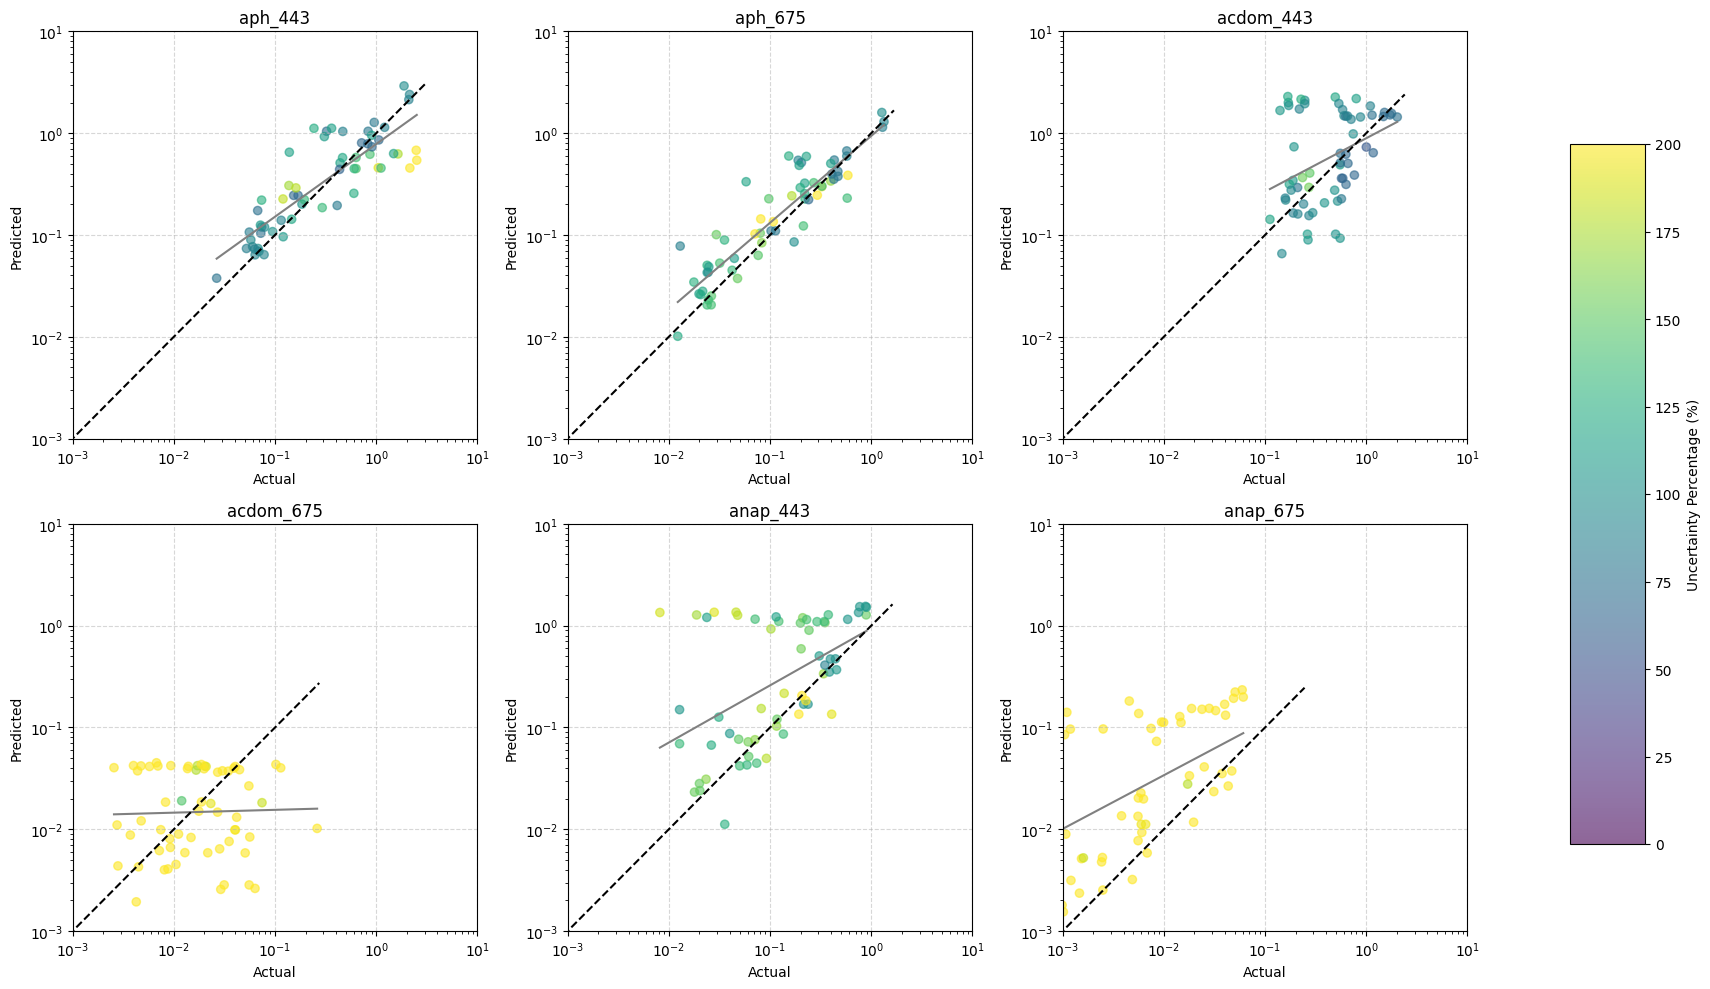

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Calculate percentage uncertainties relative to the mean predictions
percent_total_uncertainty = (np.sqrt(total_var) / mean_preds) * 100
percent_aleatoric_uncertainty = (np.sqrt(aleatoric_var) / mean_preds) * 100
percent_epistemic_uncertainty = (np.sqrt(epistemic_var) / mean_preds) * 100

# Create subplots: 2 rows, 3 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the array of axes for easy iterating
axs = axs.flatten()

# Apply the mask for values greater than 10^-4
mask = (c1_y_test > 1e-4) & (mean_preds > 1e-4)

# Normalize the uncertainty values for the colormap within the range [0, 300]
norm = plt.Normalize(vmin=0, vmax=200)

# Titles for the subplots
titles = ['aph_443', 'aph_675', 'acdom_443', 'acdom_675', 'anap_443', 'anap_675']

for i, ax in enumerate(axs):
    # Apply the mask to both x and y values
    x_values = c1_y_test[:, i][mask[:, i]]
    y_values = mean_preds[:, i][mask[:, i]]
    color_values = percent_total_uncertainty[:, i][mask[:, i]]  # Use the corresponding uncertainties

    # Scatter plot for actual vs. predicted, colored by total uncertainty
    sc = ax.scatter(x_values, y_values, c=color_values, cmap='viridis', norm=norm, alpha=0.6)
    # Linear regression in log-space
    slope, intercept, r_value, p_value, std_err = linregress(np.log(x_values), np.log(y_values))
    x_reg = np.linspace(min(x_values), max(x_values), 500)
    y_reg = np.exp(intercept + slope*np.log(x_reg))
    ax.plot(x_reg, y_reg, color='grey', label=f'Regression (R²={r_value**2:.2f})')

    # 1:1 Line
    limits = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(limits, limits, ls='--', color='black')


    ax.set_title(titles[i])
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-3, 10)
    ax.set_ylim(1e-3, 10)
    ax.grid(True, ls='--', alpha=0.5)

# Adjust layout to prevent overlap
plt.tight_layout()

# Add a single colorbar to the right of the subplots
cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])  # Position for the colorbar
cbar = plt.colorbar(mappable=sc, cax=cbar_ax, orientation='vertical', norm=norm)
cbar.set_label('Uncertainty Percentage (%)')

# Show plot
plt.show()


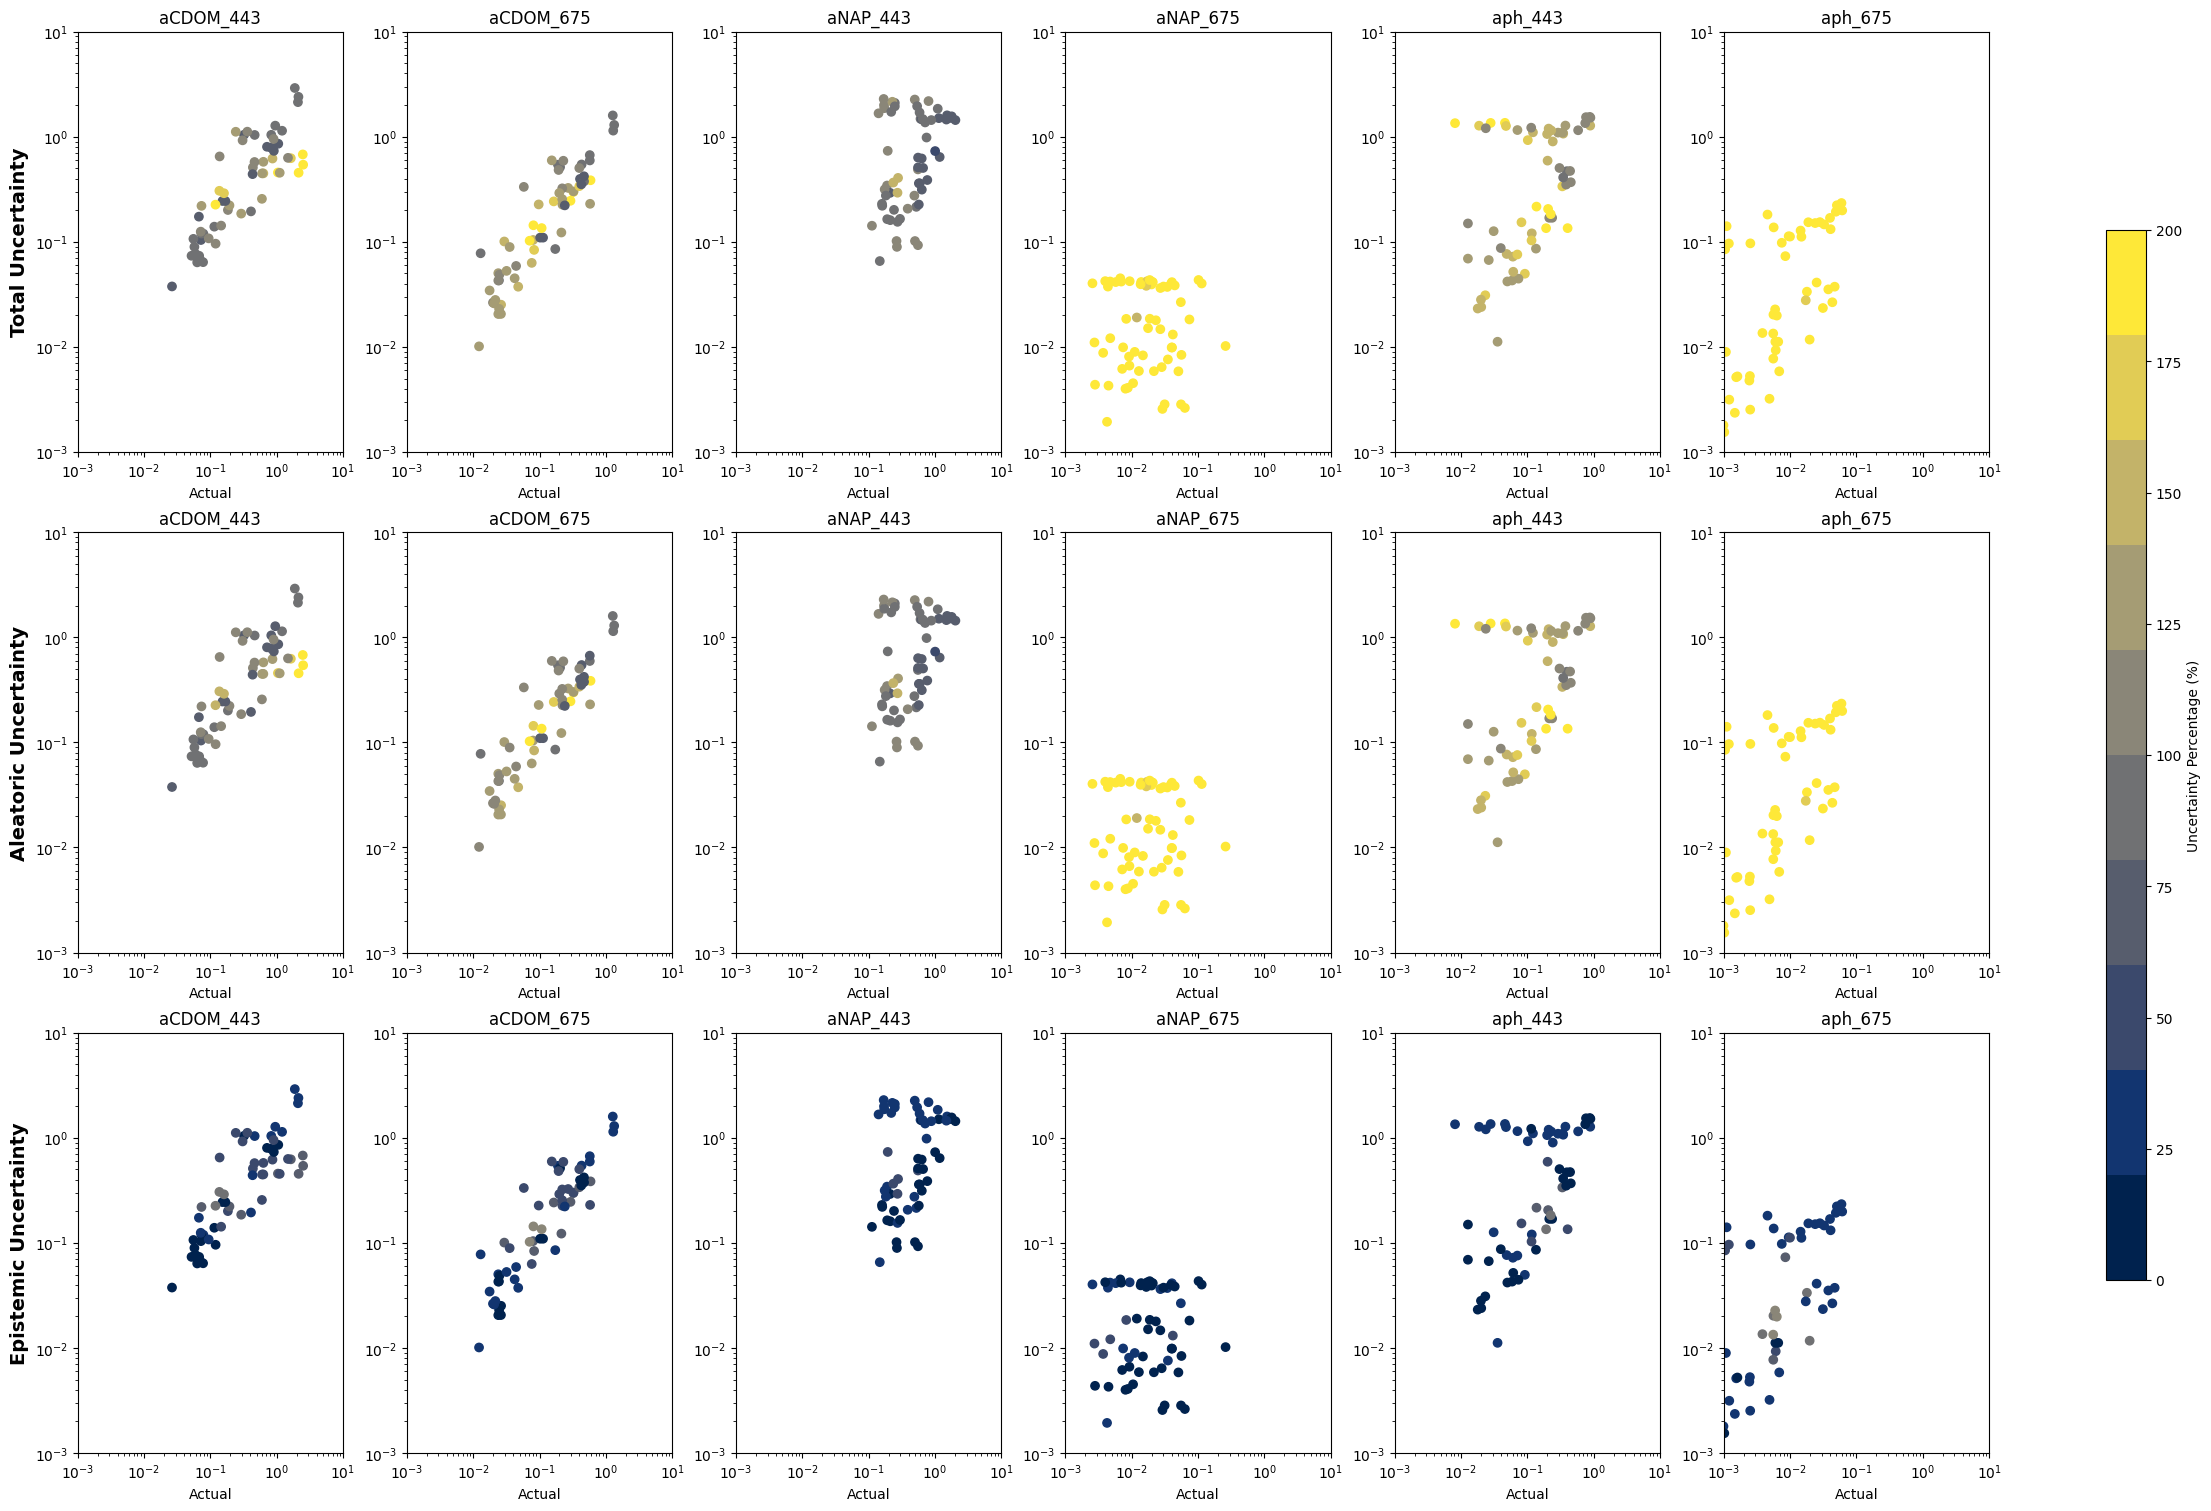

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Titles for the subplots
titles = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']
uncertainty_labels = ['Total Uncertainty', 'Aleatoric Uncertainty', 'Epistemic Uncertainty']

# Create a 3x6 subplot grid for each type of uncertainty and each variable
fig, axs = plt.subplots(3, 6, figsize=(20, 15), constrained_layout=True)

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Normalize the uncertainty values for the colormap within the range [0, 200]
norm = plt.Normalize(vmin=0, vmax=200)

# Function to create a discrete colormap
def create_discrete_colormap(cmap_name, num_bins=10):
    cmap = plt.get_cmap(cmap_name, num_bins)
    return cmap

# Create a discrete colormap with 'cividis'
cmap = create_discrete_colormap('cividis')

# Function to apply the mask and plot the data
def plot_uncertainty(ax, x_values, y_values, uncertainties, title, xlabel, ylabel=None):
    sc = ax.scatter(x_values, y_values, c=uncertainties, cmap=cmap, norm=norm, alpha=1)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel, fontweight='bold', fontsize=14)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-3, 10)
    ax.set_ylim(1e-3, 10)
    return sc

# Apply the mask for values greater than 10^-4
mask = (c1_y_test > 1e-4) & (mean_preds > 1e-4)

# Iterate over each uncertainty type
for i, uncertainty_label in enumerate(uncertainty_labels):
    # Select the appropriate uncertainty
    if uncertainty_label == 'Total Uncertainty':
        uncertainties = percent_total_uncertainty
    elif uncertainty_label == 'Aleatoric Uncertainty':
        uncertainties = percent_aleatoric_uncertainty
    else:  # 'Epistemic Uncertainty'
        uncertainties = percent_epistemic_uncertainty

    # Iterate over each variable
    for j, title in enumerate(titles):
        # Calculate the index for the current subplot
        index = i * 6 + j
        # Apply the mask to both x and y values
        x_values = c1_y_test[:, j][mask[:, j]]
        y_values = mean_preds[:, j][mask[:, j]]
        unc_values = uncertainties[:, j][mask[:, j]]
        # Plot the scatter plot for the current variable and uncertainty type
        ylabel = uncertainty_label if j == 0 else None
        sc = plot_uncertainty(axs[index], x_values, y_values, unc_values, title, 'Actual', ylabel)

# Add a colorbar to the right of the subplots
cbar_ax = fig.add_axes([1.05, 0.15, 0.02, 0.7])  # x, y, width, height
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label('Uncertainty Percentage (%)')

plt.show()


In [39]:
len(c1_y_test)

61

In [40]:
metrics_df = calculate_and_store_metrics(c1_y_test, mean_preds, c1_y_columns_test)


from joblib import load

# Combining all arrays into a single array for easier manipulation
all_data = np.vstack([
    c1_y_test,
    mean_preds,
    total_var,
    aleatoric_var,
    epistemic_var,
    std_preds
    # percent_total_uncertainty = (total_uncertainty / mean_predictions) * 100
    # percent_aleatoric_uncertainty = (aleatoric_uncertainty / mean_predictions) * 100
    # percent_epistemic_uncertainty = (epistemic_uncertainty / mean_predictions) * 100

])

# build the dict
indices = ['y_true', 'y_pred', 'total_var', 'ale_var', 'epi_var', 'std_dev']

# generate df, y_columns defined above
final_df_corrected = pd.DataFrame(all_data, columns=c1_y_columns_test)

# assign the provided indices to groups of rows
final_df_corrected.index = np.repeat(indices, [61, 61, 61, 61, 61, 61])

final_df_corrected

# generating a MultiIndex for the DataFrame
multi_index_corrected = pd.MultiIndex.from_product([indices, range(61)], names=['Category', 'Instance'])

# since all_data already combines everything correctly, simply apply the correct MultiIndex to the DataFrame
final_df_multi_indexed_corrected = pd.DataFrame(all_data, index=multi_index_corrected, columns=c1_y_columns_test)

final_df_multi_indexed_corrected

#save
file_path = 'C:/SwitchDrive/Data/prisma_results/case_1/outputs/c1_bnn_dc_preds.csv'
final_df_multi_indexed_corrected.to_csv(file_path)


# Case 2: In situ vs AC

In [41]:
c2_aco_best_model, c2_aco_best_model_index, c2_aco_mdsa_df= train_and_evaluate_models(c2_aco_X_train_scaled, c2_aco_y_train_scaled, 
                                                                                      c2_aco_X_test_scaled, c2_aco_y_test, c2_aco_y_columns_test, scaler_y=c2_aco_scaler_y, input_shape = (c2_aco_X_train_scaled.shape[1],), num_models=10)

Epoch 1/1000


C:\Users\werthemo\AppData\Local\Temp\ipykernel_12556\1588679155.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 13.0552 - val_loss: 0.6336
Epoch 2/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7117 - val_loss: 0.5024
Epoch 3/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4690 - val_loss: 0.4298
Epoch 4/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3612 - val_loss: 0.5048
Epoch 5/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4150 - val_loss: 0.3373
Epoch 6/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8182 - val_loss: 0.8017
Epoch 7/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5151 - val_loss: 0.4729
Epoch 8/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2441 - val_loss: 0.2768
Epoch 9/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1024 - val_loss: 0.3293
Epoch 10/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0086 - val_loss: 0.0976
Epoch 11/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.0473 - val_loss: -0.0811
Epoch 12/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -

C:\Users\werthemo\AppData\Local\Temp\ipykernel_12556\1588679155.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.9445 - val_loss: 0.7206
Epoch 2/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4151 - val_loss: 0.4612
Epoch 3/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3763 - val_loss: 0.6042
Epoch 4/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4414 - val_loss: 0.4544
Epoch 5/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2606 - val_loss: 0.4052
Epoch 6/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1467 - val_loss: 0.6748
Epoch 7/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4062 - val_loss: 0.5764
Epoch 8/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2944 - val_loss: 0.2989
Epoch 9/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1601 - val_loss: 0.5150
Epoch 10/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2183 - val_loss: 0.1860
Epoch 11/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0203 - val_loss: 0.0423
Epoch 12/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.0

C:\Users\werthemo\AppData\Local\Temp\ipykernel_12556\1588679155.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8755 - val_loss: 0.6298
Epoch 2/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5541 - val_loss: 0.4962
Epoch 3/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4749 - val_loss: 0.3151
Epoch 4/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3638 - val_loss: 0.4481
Epoch 5/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1688 - val_loss: 0.1797
Epoch 6/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.0344 - val_loss: 0.3655
Epoch 7/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.0558 - val_loss: -0.0206
Epoch 8/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.1794 - val_loss: -0.0100
Epoch 9/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.2339 - val_loss: -0.0730
Epoch 10/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.2503 - val_loss: -0.1801
Epoch 11/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.2995 - val_loss: -0.1163
Epoch 12/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

C:\Users\werthemo\AppData\Local\Temp\ipykernel_12556\1588679155.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8673 - val_loss: 0.8237
Epoch 2/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4108 - val_loss: 0.2373
Epoch 3/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1457 - val_loss: 0.0253
Epoch 4/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098 - val_loss: 0.0061
Epoch 5/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.1518 - val_loss: -0.1742
Epoch 6/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.2614 - val_loss: -0.0503
Epoch 7/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.3151 - val_loss: -0.1454
Epoch 8/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.3010 - val_loss: -0.1354
Epoch 9/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.3521 - val_loss: -0.3750
Epoch 10/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.3802 - val_loss: -0.3084
Epoch 11/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.4255 - val_loss: -0.1701
Epoch 12/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

C:\Users\werthemo\AppData\Local\Temp\ipykernel_12556\1588679155.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8606 - val_loss: 0.7790
Epoch 2/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7131 - val_loss: 0.7129
Epoch 3/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5503 - val_loss: 0.6303
Epoch 4/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3329 - val_loss: 0.5016
Epoch 5/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1972 - val_loss: 0.5608
Epoch 6/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1869 - val_loss: 0.5520
Epoch 7/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2152 - val_loss: 0.1995
Epoch 8/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0282 - val_loss: 0.0777
Epoch 9/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0787 - val_loss: -0.0990
Epoch 10/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.0429 - val_loss: -0.0921
Epoch 11/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.2396 - val_loss: -0.1736
Epoch 12/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss

C:\Users\werthemo\AppData\Local\Temp\ipykernel_12556\1588679155.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8458 - val_loss: 0.8076
Epoch 2/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6980 - val_loss: 0.6972
Epoch 3/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4383 - val_loss: 0.2781
Epoch 4/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2163 - val_loss: 0.6246
Epoch 5/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2909 - val_loss: 0.3666
Epoch 6/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1004 - val_loss: 0.1243
Epoch 7/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0154 - val_loss: 0.1481
Epoch 8/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0832 - val_loss: -0.0705
Epoch 9/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0827 - val_loss: -0.0419
Epoch 10/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.1256 - val_loss: -0.0988
Epoch 11/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.1531 - val_loss: -0.1234
Epoch 12/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - los

C:\Users\werthemo\AppData\Local\Temp\ipykernel_12556\1588679155.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8488 - val_loss: 0.8891
Epoch 2/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4116 - val_loss: 0.5377
Epoch 3/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0884 - val_loss: 0.2025
Epoch 4/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.1173 - val_loss: -0.1617
Epoch 5/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.2125 - val_loss: -0.1709
Epoch 6/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.2546 - val_loss: -0.1699
Epoch 7/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.2912 - val_loss: -0.1513
Epoch 8/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.3501 - val_loss: -0.2025
Epoch 9/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.3857 - val_loss: -0.3080
Epoch 10/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.3888 - val_loss: -0.2451
Epoch 11/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.4575 - val_loss: -0.1589
Epoch 12/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/s

C:\Users\werthemo\AppData\Local\Temp\ipykernel_12556\1588679155.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8436 - val_loss: 0.8806
Epoch 2/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4019 - val_loss: 0.1157
Epoch 3/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0984 - val_loss: -0.0421
Epoch 4/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0722 - val_loss: 0.0943
Epoch 5/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.1958 - val_loss: -0.1503
Epoch 6/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.2376 - val_loss: -0.0937
Epoch 7/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.2623 - val_loss: -0.3095
Epoch 8/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.3283 - val_loss: -0.1344
Epoch 9/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.3301 - val_loss: -0.0661
Epoch 10/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.3782 - val_loss: -0.1790
Epoch 11/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.4424 - val_loss: -0.1236
Epoch 12/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st

C:\Users\werthemo\AppData\Local\Temp\ipykernel_12556\1588679155.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.4176 - val_loss: 0.7041
Epoch 2/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5523 - val_loss: 0.5680
Epoch 3/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5074 - val_loss: 0.4705
Epoch 4/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5028 - val_loss: 0.7100
Epoch 5/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4208 - val_loss: 0.3650
Epoch 6/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2124 - val_loss: 0.3931
Epoch 7/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1973 - val_loss: 0.3802
Epoch 8/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1240 - val_loss: 0.2560
Epoch 9/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3152 - val_loss: 0.9081
Epoch 10/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5474 - val_loss: 0.4282
Epoch 11/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1145 - val_loss: 0.2385
Epoch 12/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.00

C:\Users\werthemo\AppData\Local\Temp\ipykernel_12556\1588679155.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8609 - val_loss: 0.6616
Epoch 2/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4189 - val_loss: 0.5598
Epoch 3/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1683 - val_loss: 0.3580
Epoch 4/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0118 - val_loss: 0.0865
Epoch 5/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.1018 - val_loss: -0.0155
Epoch 6/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.2213 - val_loss: 0.0296
Epoch 7/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.2346 - val_loss: -0.1500
Epoch 8/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.3325 - val_loss: -0.2138
Epoch 9/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.3382 - val_loss: -0.3130
Epoch 10/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.3655 - val_loss: -0.1884
Epoch 11/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.3796 - val_loss: -0.2233
Epoch 12/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

In [42]:
c2_aco_mdsa_df

aph_443    aph_675   acdom_443   acdom_675    anap_443    anap_675
0  75.399807  59.667555   89.865921  172.105776  240.289355  616.366454
1  47.084012  48.448778   95.446972  160.374035  109.818595  358.572492
2  57.872105  40.070802   93.238848  133.580507  137.298592  382.881166
3  55.944243  43.929832   90.488693  171.384443   94.246352  349.926833
4  40.903070  57.331193   70.431771  167.022943  131.173255  396.344875
5  49.890451  64.790604   86.002615  155.014063  130.558595  343.873598
6  84.939367  76.072561   87.883599  190.796626  173.818970  591.229653
7  80.191429  91.317241  103.748598  153.248290  161.690472  516.814703
8  71.428305  83.417425   99.351433  168.937866  147.328356  490.975556
9  78.593515  72.069444   99.010217  168.283690  191.488638  439.981818

In [52]:
file_path = 'C:/SwitchDrive/Data/prisma_results/case_2/case_2_bnn_dc_aco.csv'
c2_aco_mdsa_df.to_csv(file_path, index=False)

import os
folder_path = 'C:/SwitchDrive/Data/prisma_results/case_2/models/'
model_path = os.path.join(folder_path, 'bnn_dc_case_2_aco_best.keras')
# Save the model in the recommended format
c2_aco_best_model.save(model_path)

# Define the path to the saved model
c2_aco_model_path = 'C:/SwitchDrive/Data/prisma_results/case_2/models/bnn_dc_case_2_aco_best.keras'
# Load the model
c2_aco_loaded_model = tf.keras.models.load_model(c2_aco_model_path, custom_objects={'DropConnectDense': DropConnectDense, 'nll_loss': nll_loss})

C:\Users\werthemo\AppData\Local\Temp\ipykernel_12556\1588679155.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


In [53]:
mean_preds, total_var, aleatoric_var, epistemic_var, std_preds = predict_with_uncertainty(c2_aco_loaded_model, c2_aco_X_test_scaled, c2_aco_scaler_y, n_samples=100)
metrics_df = calculate_and_store_metrics(c2_aco_y_test, mean_preds, c2_aco_y_columns_test)

In [54]:
metrics_df

obs_cor         MAPD       MAD        sspb        mdsa
aph_443         50    75.283070  0.844583   32.495237   61.061706
aph_675         50    79.027220  0.676980   33.953097   44.231816
acdom_443       50   136.190766  1.277958   12.736194   91.000140
acdom_675       50   190.953164  2.138109   27.812146  171.496957
anap_443        50   840.793671  2.082723   75.773476   90.969741
anap_675        50  2658.601153  6.068237  313.222721  349.354156

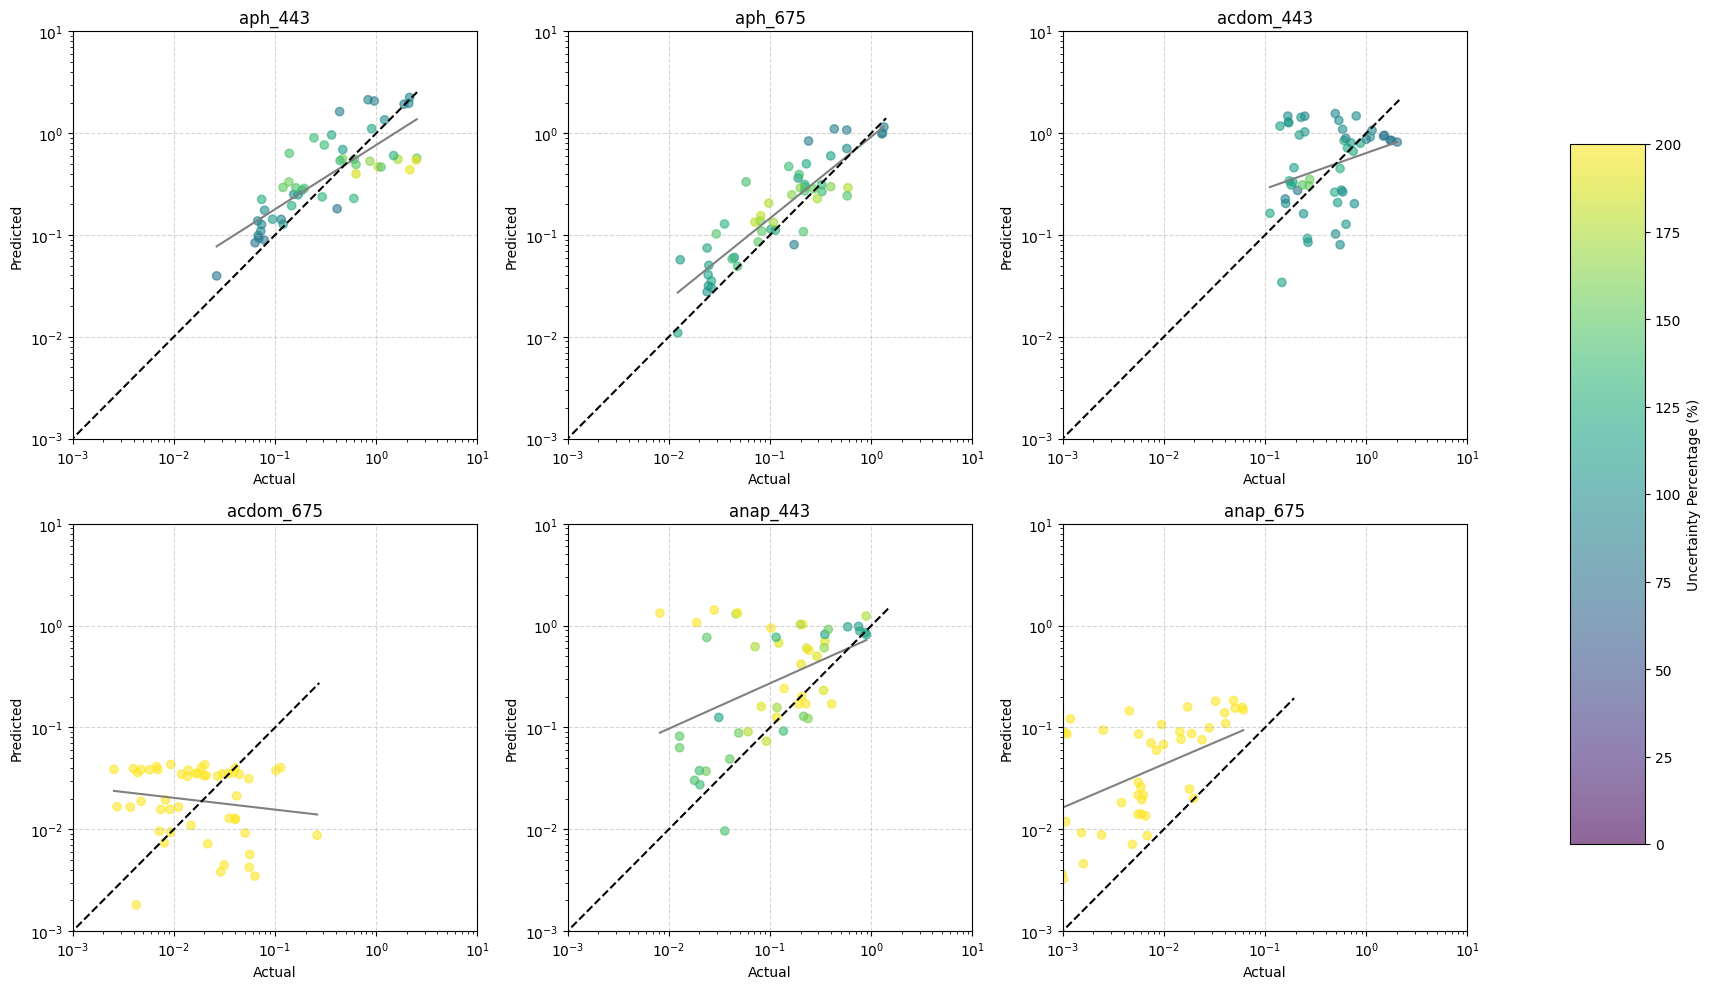

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Calculate percentage uncertainties relative to the mean predictions
percent_total_uncertainty = (np.sqrt(total_var) / mean_preds) * 100
percent_aleatoric_uncertainty = (np.sqrt(aleatoric_var) / mean_preds) * 100
percent_epistemic_uncertainty = (np.sqrt(epistemic_var) / mean_preds) * 100

# Create subplots: 2 rows, 3 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the array of axes for easy iterating
axs = axs.flatten()

# Apply the mask for values greater than 10^-4
mask = (c2_aco_y_test > 1e-4) & (mean_preds > 1e-4)

# Normalize the uncertainty values for the colormap within the range [0, 300]
norm = plt.Normalize(vmin=0, vmax=200)

# Titles for the subplots
titles = ['aph_443', 'aph_675', 'acdom_443', 'acdom_675', 'anap_443', 'anap_675']

for i, ax in enumerate(axs):
    # Apply the mask to both x and y values
    x_values = c2_aco_y_test[:, i][mask[:, i]]
    y_values = mean_preds[:, i][mask[:, i]]
    color_values = percent_total_uncertainty[:, i][mask[:, i]]  # Use the corresponding uncertainties

    # Scatter plot for actual vs. predicted, colored by total uncertainty
    sc = ax.scatter(x_values, y_values, c=color_values, cmap='viridis', norm=norm, alpha=0.6)
    # Linear regression in log-space
    slope, intercept, r_value, p_value, std_err = linregress(np.log(x_values), np.log(y_values))
    x_reg = np.linspace(min(x_values), max(x_values), 500)
    y_reg = np.exp(intercept + slope*np.log(x_reg))
    ax.plot(x_reg, y_reg, color='grey', label=f'Regression (R²={r_value**2:.2f})')

    # 1:1 Line
    limits = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(limits, limits, ls='--', color='black')


    ax.set_title(titles[i])
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-3, 10)
    ax.set_ylim(1e-3, 10)
    ax.grid(True, ls='--', alpha=0.5)

# Adjust layout to prevent overlap
plt.tight_layout()

# Add a single colorbar to the right of the subplots
cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])  # Position for the colorbar
cbar = plt.colorbar(mappable=sc, cax=cbar_ax, orientation='vertical', norm=norm)
cbar.set_label('Uncertainty Percentage (%)')

# Show plot
plt.show()


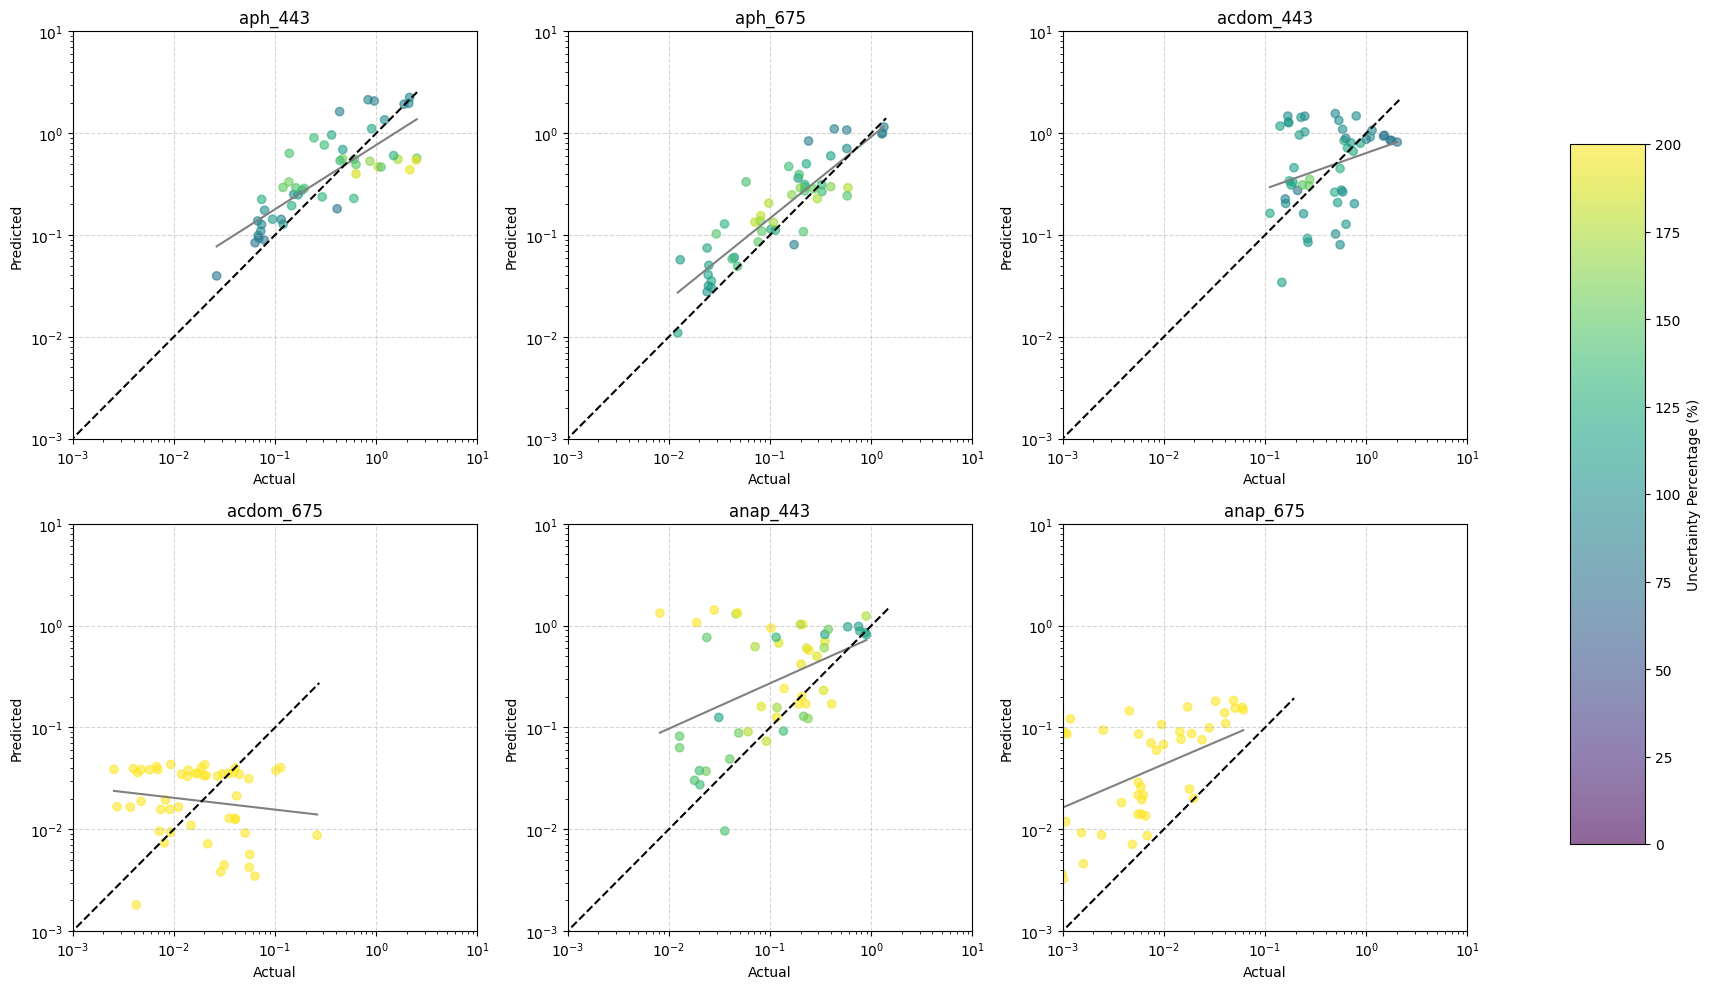

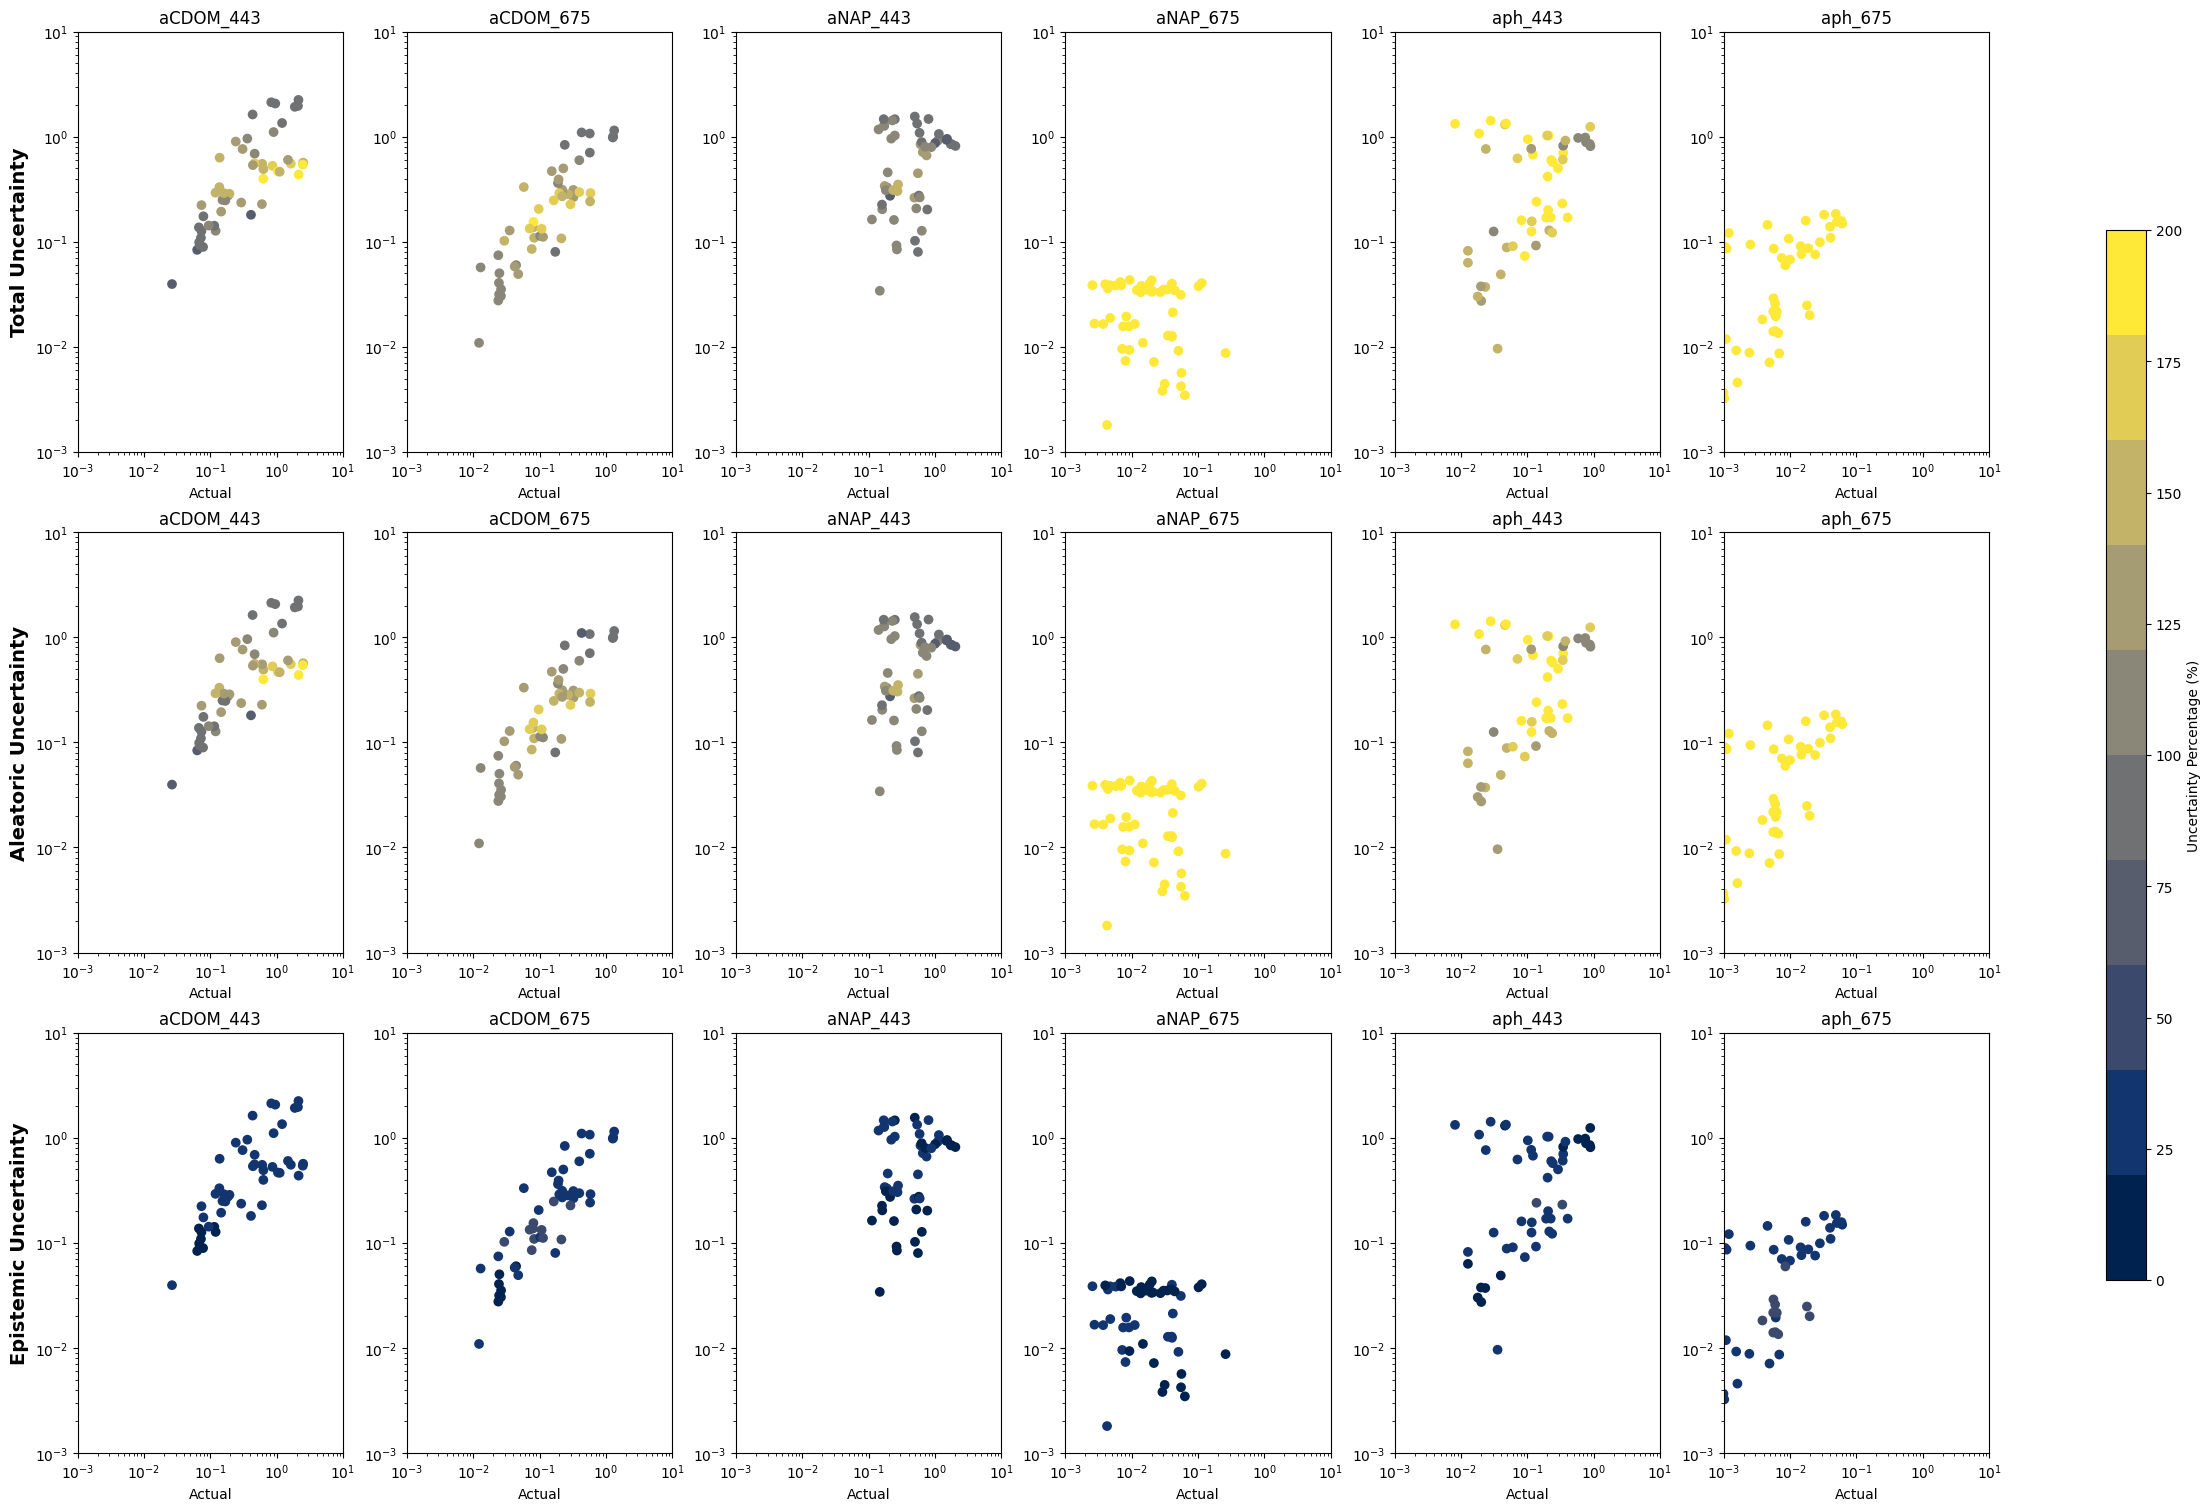

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Calculate percentage uncertainties relative to the mean predictions
percent_total_uncertainty = (np.sqrt(total_var) / mean_preds) * 100
percent_aleatoric_uncertainty = (np.sqrt(aleatoric_var) / mean_preds) * 100
percent_epistemic_uncertainty = (np.sqrt(epistemic_var) / mean_preds) * 100

# Create subplots: 2 rows, 3 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the array of axes for easy iterating
axs = axs.flatten()

# Apply the mask for values greater than 10^-4
mask = (c2_aco_y_test > 1e-4) & (mean_preds > 1e-4)

# Normalize the uncertainty values for the colormap within the range [0, 300]
norm = plt.Normalize(vmin=0, vmax=200)

# Titles for the subplots
titles = ['aph_443', 'aph_675', 'acdom_443', 'acdom_675', 'anap_443', 'anap_675']

for i, ax in enumerate(axs):
    # Apply the mask to both x and y values
    x_values = c2_aco_y_test[:, i][mask[:, i]]
    y_values = mean_preds[:, i][mask[:, i]]
    color_values = percent_total_uncertainty[:, i][mask[:, i]]  # Use the corresponding uncertainties

    # Scatter plot for actual vs. predicted, colored by total uncertainty
    sc = ax.scatter(x_values, y_values, c=color_values, cmap='viridis', norm=norm, alpha=0.6)
    # Linear regression in log-space
    slope, intercept, r_value, p_value, std_err = linregress(np.log(x_values), np.log(y_values))
    x_reg = np.linspace(min(x_values), max(x_values), 500)
    y_reg = np.exp(intercept + slope*np.log(x_reg))
    ax.plot(x_reg, y_reg, color='grey', label=f'Regression (R²={r_value**2:.2f})')

    # 1:1 Line
    limits = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(limits, limits, ls='--', color='black')


    ax.set_title(titles[i])
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-3, 10)
    ax.set_ylim(1e-3, 10)
    ax.grid(True, ls='--', alpha=0.5)

# Adjust layout to prevent overlap
plt.tight_layout()

# Add a single colorbar to the right of the subplots
cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])  # Position for the colorbar
cbar = plt.colorbar(mappable=sc, cax=cbar_ax, orientation='vertical', norm=norm)
cbar.set_label('Uncertainty Percentage (%)')

# Show plot
plt.show()

# Titles for the subplots
titles = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']
uncertainty_labels = ['Total Uncertainty', 'Aleatoric Uncertainty', 'Epistemic Uncertainty']

# Create a 3x6 subplot grid for each type of uncertainty and each variable
fig, axs = plt.subplots(3, 6, figsize=(20, 15), constrained_layout=True)

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Normalize the uncertainty values for the colormap within the range [0, 200]
norm = plt.Normalize(vmin=0, vmax=200)

# Function to create a discrete colormap
def create_discrete_colormap(cmap_name, num_bins=10):
    cmap = plt.get_cmap(cmap_name, num_bins)
    return cmap

# Create a discrete colormap with 'cividis'
cmap = create_discrete_colormap('cividis')

# Function to apply the mask and plot the data
def plot_uncertainty(ax, x_values, y_values, uncertainties, title, xlabel, ylabel=None):
    sc = ax.scatter(x_values, y_values, c=uncertainties, cmap=cmap, norm=norm, alpha=1)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel, fontweight='bold', fontsize=14)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-3, 10)
    ax.set_ylim(1e-3, 10)
    return sc

# Apply the mask for values greater than 10^-4
mask = (c2_aco_y_test > 1e-4) & (mean_preds > 1e-4)

# Iterate over each uncertainty type
for i, uncertainty_label in enumerate(uncertainty_labels):
    # Select the appropriate uncertainty
    if uncertainty_label == 'Total Uncertainty':
        uncertainties = percent_total_uncertainty
    elif uncertainty_label == 'Aleatoric Uncertainty':
        uncertainties = percent_aleatoric_uncertainty
    else:  # 'Epistemic Uncertainty'
        uncertainties = percent_epistemic_uncertainty

    # Iterate over each variable
    for j, title in enumerate(titles):
        # Calculate the index for the current subplot
        index = i * 6 + j
        # Apply the mask to both x and y values
        x_values = c2_aco_y_test[:, j][mask[:, j]]
        y_values = mean_preds[:, j][mask[:, j]]
        unc_values = uncertainties[:, j][mask[:, j]]
        # Plot the scatter plot for the current variable and uncertainty type
        ylabel = uncertainty_label if j == 0 else None
        sc = plot_uncertainty(axs[index], x_values, y_values, unc_values, title, 'Actual', ylabel)

# Add a colorbar to the right of the subplots
cbar_ax = fig.add_axes([1.05, 0.15, 0.02, 0.7])  # x, y, width, height
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label('Uncertainty Percentage (%)')

plt.show()


In [58]:
len(c2_aco_y_test)

50

In [59]:
metrics_df = calculate_and_store_metrics(c2_aco_y_test, mean_preds, c2_aco_y_columns_test)


from joblib import load

# Combining all arrays into a single array for easier manipulation
all_data = np.vstack([
    c2_aco_y_test,
    mean_preds,
    total_var,
    aleatoric_var,
    epistemic_var,
    std_preds
    # percent_total_uncertainty = (total_uncertainty / mean_predictions) * 100
    # percent_aleatoric_uncertainty = (aleatoric_uncertainty / mean_predictions) * 100
    # percent_epistemic_uncertainty = (epistemic_uncertainty / mean_predictions) * 100

])

# build the dict
indices = ['y_true', 'y_pred', 'total_var', 'ale_var', 'epi_var', 'std_dev']

# generate df, y_columns defined above
final_df_corrected = pd.DataFrame(all_data, columns=c2_aco_y_columns_test)

# assign the provided indices to groups of rows
final_df_corrected.index = np.repeat(indices, [50, 50, 50, 50, 50, 50])

final_df_corrected

# generating a MultiIndex for the DataFrame
multi_index_corrected = pd.MultiIndex.from_product([indices, range(50)], names=['Category', 'Instance'])

# since all_data already combines everything correctly, simply apply the correct MultiIndex to the DataFrame
final_df_multi_indexed_corrected = pd.DataFrame(all_data, index=multi_index_corrected, columns=c1_y_columns_test)

final_df_multi_indexed_corrected

#save
file_path = 'C:/SwitchDrive/Data/prisma_results/case_2/outputs/c2_bnn_dc_aco_preds.csv'
final_df_multi_indexed_corrected.to_csv(file_path)


In [60]:
metrics_df

obs_cor         MAPD       MAD        sspb        mdsa
aph_443         50    75.283070  0.844583   32.495237   61.061706
aph_675         50    79.027220  0.676980   33.953097   44.231816
acdom_443       50   136.190766  1.277958   12.736194   91.000140
acdom_675       50   190.953164  2.138109   27.812146  171.496957
anap_443        50   840.793671  2.082723   75.773476   90.969741
anap_675        50  2658.601153  6.068237  313.222721  349.354156

# Case 2: In situ vs L2 AC

In [62]:
c2_l2_best_model, c2_l2_best_model_index, c2_l2_mdsa_df= train_and_evaluate_models(c2_l2_X_train_scaled, c2_l2_y_train_scaled, c2_l2_X_test_scaled, c2_l2_y_test, c2_l2_y_columns_test, scaler_y=c2_l2_scaler_y, input_shape = (c2_l2_X_train_scaled.shape[1],), num_models=10)

Epoch 1/1000


C:\Users\werthemo\AppData\Local\Temp\ipykernel_12556\1588679155.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8493 - val_loss: 0.7365
Epoch 2/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7242 - val_loss: 0.6465
Epoch 3/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4501 - val_loss: 0.2008
Epoch 4/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1879 - val_loss: 0.4346
Epoch 5/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1427 - val_loss: 0.0817
Epoch 6/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5254 - val_loss: 0.7870
Epoch 7/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3786 - val_loss: 0.7978
Epoch 8/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2166 - val_loss: 0.2327
Epoch 9/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0648 - val_loss: 0.0319
Epoch 10/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.0490 - val_loss: -0.1019
Epoch 11/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.0563 - val_loss: 0.3517
Epoch 12/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0

C:\Users\werthemo\AppData\Local\Temp\ipykernel_12556\1588679155.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8518 - val_loss: 0.5385
Epoch 2/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6187 - val_loss: 0.2815
Epoch 3/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3275 - val_loss: 0.3367
Epoch 4/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2825 - val_loss: 0.2094
Epoch 5/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3001 - val_loss: 0.3845
Epoch 6/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2083 - val_loss: 0.3121
Epoch 7/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0837 - val_loss: 0.0409
Epoch 8/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.0482 - val_loss: 0.1561
Epoch 9/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.0736 - val_loss: -0.1240
Epoch 10/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.1038 - val_loss: -0.1463
Epoch 11/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.1831 - val_loss: -0.0519
Epoch 12/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - los

C:\Users\werthemo\AppData\Local\Temp\ipykernel_12556\1588679155.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8492 - val_loss: 0.5709
Epoch 2/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2882 - val_loss: 0.2118
Epoch 3/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0440 - val_loss: 0.0409
Epoch 4/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.0682 - val_loss: 0.3047
Epoch 5/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.1183 - val_loss: 0.3778
Epoch 6/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.0549 - val_loss: -0.0431
Epoch 7/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.2675 - val_loss: -0.0951
Epoch 8/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.3202 - val_loss: -0.0920
Epoch 9/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.3045 - val_loss: -0.2270
Epoch 10/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.3719 - val_loss: -0.0242
Epoch 11/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.3911 - val_loss: -0.2923
Epoch 12/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/ste

C:\Users\werthemo\AppData\Local\Temp\ipykernel_12556\1588679155.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8597 - val_loss: 0.5922
Epoch 2/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5635 - val_loss: 0.4738
Epoch 3/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6782 - val_loss: 0.5298
Epoch 4/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3081 - val_loss: 0.7582
Epoch 5/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2998 - val_loss: 0.1843
Epoch 6/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1171 - val_loss: 0.2582
Epoch 7/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0959 - val_loss: 0.0718
Epoch 8/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.0633 - val_loss: 0.1792
Epoch 9/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.0619 - val_loss: -0.1139
Epoch 10/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.1688 - val_loss: -0.1510
Epoch 11/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.1825 - val_loss: -0.2049
Epoch 12/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - los

C:\Users\werthemo\AppData\Local\Temp\ipykernel_12556\1588679155.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.2412 - val_loss: 0.7437
Epoch 2/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6656 - val_loss: 0.4737
Epoch 3/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7360 - val_loss: 0.4763
Epoch 4/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7701 - val_loss: 0.5620
Epoch 5/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8174 - val_loss: 0.4321
Epoch 6/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4845 - val_loss: 0.6776
Epoch 7/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4785 - val_loss: 0.7781
Epoch 8/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3559 - val_loss: 0.4249
Epoch 9/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2374 - val_loss: 0.1843
Epoch 10/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0643 - val_loss: 0.0281
Epoch 11/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0615 - val_loss: 0.2674
Epoch 12/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.02

C:\Users\werthemo\AppData\Local\Temp\ipykernel_12556\1588679155.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9171 - val_loss: 0.8482
Epoch 2/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5566 - val_loss: 0.6939
Epoch 3/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3491 - val_loss: 0.3812
Epoch 4/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2212 - val_loss: 0.3399
Epoch 5/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0489 - val_loss: 0.0323
Epoch 6/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.0802 - val_loss: 0.0327
Epoch 7/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.1691 - val_loss: -0.0273
Epoch 8/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.1744 - val_loss: -0.0887
Epoch 9/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.3092 - val_loss: -0.1250
Epoch 10/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.3005 - val_loss: -0.1916
Epoch 11/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.3406 - val_loss: -0.3543
Epoch 12/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

C:\Users\werthemo\AppData\Local\Temp\ipykernel_12556\1588679155.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0869 - val_loss: 0.9805
Epoch 2/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1173 - val_loss: 0.4382
Epoch 3/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4959 - val_loss: 0.8210
Epoch 4/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5266 - val_loss: 0.4382
Epoch 5/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3532 - val_loss: 0.4820
Epoch 6/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4064 - val_loss: 0.2364
Epoch 7/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2071 - val_loss: 0.0392
Epoch 8/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0393 - val_loss: 0.0596
Epoch 9/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0474 - val_loss: 0.6806
Epoch 10/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2670 - val_loss: 0.4424
Epoch 11/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0545 - val_loss: 0.1628
Epoch 12/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.0

C:\Users\werthemo\AppData\Local\Temp\ipykernel_12556\1588679155.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.2644 - val_loss: 0.7724
Epoch 2/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5671 - val_loss: 0.7687
Epoch 3/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4183 - val_loss: 0.5563
Epoch 4/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3458 - val_loss: 0.4112
Epoch 5/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3272 - val_loss: 0.2156
Epoch 6/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4115 - val_loss: 0.3094
Epoch 7/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1884 - val_loss: 0.2059
Epoch 8/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2902 - val_loss: 0.1558
Epoch 9/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0613 - val_loss: 0.0722
Epoch 10/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.0404 - val_loss: 0.3878
Epoch 11/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0509 - val_loss: 0.0853
Epoch 12/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.

C:\Users\werthemo\AppData\Local\Temp\ipykernel_12556\1588679155.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8658 - val_loss: 0.3032
Epoch 2/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3119 - val_loss: 0.6682
Epoch 3/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2393 - val_loss: 0.0953
Epoch 4/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3594 - val_loss: 0.5436
Epoch 5/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1176 - val_loss: 0.2408
Epoch 6/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.1218 - val_loss: -0.0938
Epoch 7/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.2124 - val_loss: -0.0387
Epoch 8/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.2529 - val_loss: 0.1072
Epoch 9/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.2467 - val_loss: 0.2094
Epoch 10/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.2785 - val_loss: -0.2044
Epoch 11/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.3207 - val_loss: -0.2725
Epoch 12/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - 

C:\Users\werthemo\AppData\Local\Temp\ipykernel_12556\1588679155.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8655 - val_loss: 0.7355
Epoch 2/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4829 - val_loss: 0.2367
Epoch 3/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8951 - val_loss: 0.4732
Epoch 4/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2746 - val_loss: 0.6020
Epoch 5/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2921 - val_loss: 0.2085
Epoch 6/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1202 - val_loss: 0.3340
Epoch 7/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1059 - val_loss: 0.1478
Epoch 8/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1862 - val_loss: 0.0318
Epoch 9/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.0129 - val_loss: 0.1715
Epoch 10/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.0510 - val_loss: -0.0591
Epoch 11/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.1140 - val_loss: -0.1671
Epoch 12/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss:

In [63]:
c2_l2_mdsa_df

aph_443     aph_675   acdom_443   acdom_675    anap_443    anap_675
0  158.509312  219.125773   94.086412  158.604131  190.557061  812.190235
1  111.829711  142.243452  126.144133  169.432694  189.558525  715.841187
2   67.999855   75.102114  102.922907  180.087430  112.542268  244.557207
3   85.890815  152.250306  105.049428  176.196447  169.753604  611.249186
4   99.251321  157.243122  124.748548  171.714265  169.972150  632.931567
5  141.917630  125.933987   92.739014  143.568386  148.925602  848.584462
6  120.682780  143.153811   99.776055  165.678988  151.307373  563.987776
7   89.279190   66.869106   83.397636  187.346575   81.853289  364.165288
8   78.443734  143.532916  106.150466  163.487502  109.744562  384.491873
9   90.905332  114.248813  126.437227  191.875037  129.690657  453.321686

In [65]:
file_path = 'C:/SwitchDrive/Data/prisma_results/case_2/case_2_bnn_dc_l2.csv'
c2_l2_mdsa_df.to_csv(file_path, index=False)

import os
folder_path = 'C:/SwitchDrive/Data/prisma_results/case_2/models/'
model_path = os.path.join(folder_path, 'bnn_dc_case_2_l2_best.keras')
# Save the model in the recommended format
c2_l2_best_model.save(model_path)

# Define the path to the saved model
c2_l2_model_path = 'C:/SwitchDrive/Data/prisma_results/case_2/models/bnn_dc_case_2_l2_best.keras'
# Load the model
c2_l2_loaded_model = tf.keras.models.load_model(c2_l2_model_path, custom_objects={'DropConnectDense': DropConnectDense, 'nll_loss': nll_loss})

C:\Users\werthemo\AppData\Local\Temp\ipykernel_12556\1588679155.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


In [76]:
mean_preds, total_var, aleatoric_var, epistemic_var, std_preds = predict_with_uncertainty(c2_l2_loaded_model, c2_l2_X_test_scaled, c2_l2_scaler_y, n_samples=100)
metrics_df = calculate_and_store_metrics(c2_l2_y_test, mean_preds, c2_l2_y_columns_test)

In [77]:
metrics_df

obs_cor         MAPD       MAD        sspb        mdsa
aph_443         50    83.576320  0.851931   35.296137   84.419018
aph_675         50    93.330482  0.798934   52.731436   63.885875
acdom_443       50   126.154833  1.320497  -16.450200   85.620079
acdom_675       50   161.424530  2.237124  -11.118709  162.562252
anap_443        50   821.441019  1.935662   37.872540   74.087504
anap_675        50  4690.196332  6.701322  303.631283  307.890817

In [78]:
from joblib import load

# Combining all arrays into a single array for easier manipulation
all_data = np.vstack([
    c2_l2_y_test,
    mean_preds,
    total_var,
    aleatoric_var,
    epistemic_var,
    std_preds
    # percent_total_uncertainty = (total_uncertainty / mean_predictions) * 100
    # percent_aleatoric_uncertainty = (aleatoric_uncertainty / mean_predictions) * 100
    # percent_epistemic_uncertainty = (epistemic_uncertainty / mean_predictions) * 100

])

# build the dict
indices = ['y_true', 'y_pred', 'total_var', 'ale_var', 'epi_var', 'std_dev']

# generate df, y_columns defined above
final_df_corrected = pd.DataFrame(all_data, columns=c2_l2_y_columns_test)

# assign the provided indices to groups of rows
final_df_corrected.index = np.repeat(indices, [50, 50, 50, 50, 50, 50])

final_df_corrected

# generating a MultiIndex for the DataFrame
multi_index_corrected = pd.MultiIndex.from_product([indices, range(50)], names=['Category', 'Instance'])

# since all_data already combines everything correctly, simply apply the correct MultiIndex to the DataFrame
final_df_multi_indexed_corrected = pd.DataFrame(all_data, index=multi_index_corrected, columns=c2_l2_y_columns_test)

final_df_multi_indexed_corrected

#save
file_path = 'C:/SwitchDrive/Data/prisma_results/case_2/outputs/c2_bnn_dc_l2_preds.csv'
final_df_multi_indexed_corrected.to_csv(file_path)


# Case 3: In situ combined vs AC

In [17]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.preprocessing import RobustScaler

# Select Rrs values in 5 nm steps and target variables
rrs_columns_train = ['406_prisma_local', '415_prisma_local',
       '423_prisma_local', '431_prisma_local', '438_prisma_local',
       '446_prisma_local', '453_prisma_local', '460_prisma_local',
       '468_prisma_local', '475_prisma_local', '482_prisma_local',
       '489_prisma_local', '497_prisma_local', '504_prisma_local',
       '512_prisma_local', '519_prisma_local', '527_prisma_local',
       '535_prisma_local', '542_prisma_local', '550_prisma_local',
       '559_prisma_local', '567_prisma_local', '575_prisma_local',
       '583_prisma_local', '592_prisma_local', '601_prisma_local',
       '609_prisma_local', '618_prisma_local', '627_prisma_local',
       '636_prisma_local', '645_prisma_local', '655_prisma_local',
       '664_prisma_local', '674_prisma_local', '684_prisma_local',
       '694_prisma_local']

y_columns_train = ['ph_443', 'ph_675', 'cdom_443', 'cdom_675', 'nap_443', 'nap_675']

# Extract features and target variables
c3_X_train = combined_local_train_df[rrs_columns_train].values
c3_y_train = combined_local_train_df[y_columns_train].values

# scale train input
c3_scaler_x = RobustScaler()
c3_X_train_scaled = c3_scaler_x.fit_transform(c3_X_train)

# Scale train output
c3_y_train_log = np.log(c3_y_train)
c3_scaler_y = MinMaxScaler(feature_range=(-1, 1))
c3_y_train_scaled = c3_scaler_y.fit_transform(c3_y_train_log)

### test

#Select Rrs values in 5 nm steps and target variables
c3_l2_rrs_columns_test = ['L2C_406', 'L2C_415', 'L2C_423', 'L2C_431', 'L2C_438',
       'L2C_446', 'L2C_453', 'L2C_460', 'L2C_468', 'L2C_475', 'L2C_482',
       'L2C_489', 'L2C_497', 'L2C_504', 'L2C_512', 'L2C_519', 'L2C_527',
       'L2C_535', 'L2C_542', 'L2C_550', 'L2C_559', 'L2C_567', 'L2C_575',
       'L2C_583', 'L2C_592', 'L2C_601', 'L2C_609', 'L2C_618', 'L2C_627',
       'L2C_636', 'L2C_645', 'L2C_655', 'L2C_664', 'L2C_674', 'L2C_684',
       'L2C_694']

c3_aco_rrs_columns_test = ['aco_406', 'aco_415', 'aco_423', 'aco_431', 'aco_438', 'aco_446',
       'aco_453', 'aco_460', 'aco_468', 'aco_475', 'aco_482', 'aco_489',
       'aco_497', 'aco_504', 'aco_512', 'aco_519', 'aco_527', 'aco_535',
       'aco_542', 'aco_550', 'aco_559', 'aco_567', 'aco_575', 'aco_583',
       'aco_592', 'aco_601', 'aco_609', 'aco_618', 'aco_627', 'aco_636',
       'aco_645', 'aco_655', 'aco_664', 'aco_674', 'aco_684', 'aco_694']

c3_y_columns_test = ['aph_443', 'aph_675', 'acdom_443', 'acdom_675', 'anap_443', 'anap_675']

### L2
# Extract features and target variables
c3_l2_X_test = prisma_l2[c3_l2_rrs_columns_test].values
c3_l2_y_test = prisma_l2[c3_y_columns_test].values

# scale test input
c3_l2_X_test_scaled = c3_scaler_x.transform(c3_l2_X_test)

# Scale test output
c3_l2_y_test_log = np.log(c3_l2_y_test)
c3_l2_y_test_scaled = c3_scaler_y.transform(c3_l2_y_test_log)

# Display the shapes of the datasets
print("Training set shape:", c3_X_train.shape, c3_y_train_scaled.shape)
print("Test set shape:", c3_l2_X_test.shape, c3_l2_y_test_scaled.shape)

### ACO
# Extract features and target variables
c3_aco_X_test = prisma_aco[c3_aco_rrs_columns_test].values
c3_aco_y_test = prisma_aco[c3_y_columns_test].values

# scale test input
c3_aco_X_test_scaled = c3_scaler_x.transform(c3_aco_X_test)

# Scale test output
c3_aco_y_test_log = np.log(c3_aco_y_test)
c3_aco_y_test_scaled = c3_scaler_y.transform(c3_aco_y_test_log)

# Display the shapes of the datasets
print("Training set shape:", c3_X_train.shape, c3_y_train_scaled.shape)
print("Test set shape:", c3_aco_X_test.shape, c3_aco_y_test_scaled.shape)



Training set shape: (2344, 36) (2344, 6)
Test set shape: (50, 36) (50, 6)
Training set shape: (2344, 36) (2344, 6)
Test set shape: (50, 36) (50, 6)


In [80]:
c3_l2_best_model, c3_l2_best_model_index, c3_l2_mdsa_df= train_and_evaluate_models(c3_X_train_scaled, c3_y_train_scaled, c3_l2_X_test_scaled, c3_l2_y_test, c3_y_columns_test, scaler_y=c3_scaler_y, input_shape = (c3_X_train_scaled.shape[1],), num_models=10)

Epoch 1/1000


C:\Users\werthemo\AppData\Local\Temp\ipykernel_12556\1588679155.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8807 - val_loss: 0.4318
Epoch 2/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5823 - val_loss: 0.5131
Epoch 3/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5295 - val_loss: 0.3183
Epoch 4/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3107 - val_loss: 0.1003
Epoch 5/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1103 - val_loss: 0.0231
Epoch 6/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0825 - val_loss: -0.0845
Epoch 7/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.0451 - val_loss: -0.1961
Epoch 8/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.0557 - val_loss: -0.2348
Epoch 9/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.1411 - val_loss: -0.3405
Epoch 10/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.2092 - val_loss: -0.3476
Epoch 11/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.2251 - val_loss: -0.3458
Epoch 12/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

C:\Users\werthemo\AppData\Local\Temp\ipykernel_12556\1588679155.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8575 - val_loss: 0.4001
Epoch 2/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3697 - val_loss: 0.1633
Epoch 3/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1214 - val_loss: -0.1400
Epoch 4/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.0700 - val_loss: -0.2720
Epoch 5/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.2066 - val_loss: -0.3232
Epoch 6/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.2533 - val_loss: -0.3788
Epoch 7/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.2926 - val_loss: -0.4322
Epoch 8/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.3656 - val_loss: -0.4943
Epoch 9/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.3406 - val_loss: -0.3572
Epoch 10/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.3259 - val_loss: -0.4907
Epoch 11/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.4038 - val_loss: -0.4624
Epoch 12/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/

C:\Users\werthemo\AppData\Local\Temp\ipykernel_12556\1588679155.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8667 - val_loss: 0.5092
Epoch 2/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4090 - val_loss: 0.1617
Epoch 3/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2338 - val_loss: -0.0884
Epoch 4/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9604 - val_loss: 0.2169
Epoch 5/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2157 - val_loss: -0.1007
Epoch 6/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0187 - val_loss: -0.1680
Epoch 7/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.0694 - val_loss: -0.2749
Epoch 8/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.1379 - val_loss: -0.2954
Epoch 9/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.1208 - val_loss: -0.3680
Epoch 10/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.2275 - val_loss: -0.2742
Epoch 11/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.2328 - val_loss: -0.3538
Epoch 12/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/ste

C:\Users\werthemo\AppData\Local\Temp\ipykernel_12556\1588679155.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8241 - val_loss: 0.2499
Epoch 2/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4600 - val_loss: 0.3122
Epoch 3/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3637 - val_loss: 0.0617
Epoch 4/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8924 - val_loss: 0.1398
Epoch 5/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1434 - val_loss: -0.0726
Epoch 6/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1805 - val_loss: -0.0430
Epoch 7/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0164 - val_loss: -0.1649
Epoch 8/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.0961 - val_loss: -0.2036
Epoch 9/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.1405 - val_loss: -0.2454
Epoch 10/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.1675 - val_loss: -0.3818
Epoch 11/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.2123 - val_loss: -0.3070
Epoch 12/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

C:\Users\werthemo\AppData\Local\Temp\ipykernel_12556\1588679155.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8872 - val_loss: 0.4850
Epoch 2/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4582 - val_loss: 0.5529
Epoch 3/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4770 - val_loss: 0.1984
Epoch 4/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2013 - val_loss: 0.0815
Epoch 5/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0598 - val_loss: -0.1281
Epoch 6/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.0055 - val_loss: -0.0757
Epoch 7/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.0110 - val_loss: -0.2127
Epoch 8/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.1612 - val_loss: -0.3236
Epoch 9/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.2351 - val_loss: -0.2422
Epoch 10/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.2108 - val_loss: -0.4259
Epoch 11/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.3009 - val_loss: -0.4298
Epoch 12/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

C:\Users\werthemo\AppData\Local\Temp\ipykernel_12556\1588679155.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8267 - val_loss: 0.2477
Epoch 2/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4462 - val_loss: 0.1743
Epoch 3/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3864 - val_loss: 0.2056
Epoch 4/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1789 - val_loss: -0.0988
Epoch 5/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0130 - val_loss: -0.1084
Epoch 6/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.1032 - val_loss: -0.2979
Epoch 7/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.1710 - val_loss: -0.0825
Epoch 8/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0956 - val_loss: -0.3619
Epoch 9/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0167 - val_loss: -0.0750
Epoch 10/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0333 - val_loss: -0.3180
Epoch 11/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.1806 - val_loss: -0.2804
Epoch 12/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

C:\Users\werthemo\AppData\Local\Temp\ipykernel_12556\1588679155.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8567 - val_loss: 0.3668
Epoch 2/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8580 - val_loss: 0.1652
Epoch 3/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1763 - val_loss: -0.0463
Epoch 4/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0602 - val_loss: -1.4004e-04
Epoch 5/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -7.2402e-04 - val_loss: -0.1665
Epoch 6/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1331 - val_loss: 0.3600
Epoch 7/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2827 - val_loss: -0.2261
Epoch 8/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.1203 - val_loss: -0.2383
Epoch 9/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0648 - val_loss: -0.1026
Epoch 10/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0861 - val_loss: -0.3032
Epoch 11/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.2054 - val_loss: -0.3635
Epoch 12/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 

C:\Users\werthemo\AppData\Local\Temp\ipykernel_12556\1588679155.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8460 - val_loss: 0.5432
Epoch 2/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4841 - val_loss: 0.0551
Epoch 3/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1336 - val_loss: -0.0553
Epoch 4/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.0514 - val_loss: -0.2615
Epoch 5/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.1320 - val_loss: -0.2685
Epoch 6/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.1248 - val_loss: -0.4131
Epoch 7/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.2878 - val_loss: -0.3349
Epoch 8/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.2870 - val_loss: -0.4713
Epoch 9/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.3562 - val_loss: -0.5149
Epoch 10/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.3671 - val_loss: -0.4632
Epoch 11/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.3733 - val_loss: -0.5011
Epoch 12/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/

C:\Users\werthemo\AppData\Local\Temp\ipykernel_12556\1588679155.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.8529 - val_loss: 0.3695
Epoch 2/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3226 - val_loss: 0.4022
Epoch 3/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5194 - val_loss: 0.6063
Epoch 4/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5791 - val_loss: 0.2278
Epoch 5/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0386 - val_loss: 0.3686
Epoch 6/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3880 - val_loss: 0.2311
Epoch 7/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2736 - val_loss: 0.1317
Epoch 8/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2292 - val_loss: 0.2548
Epoch 9/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2040 - val_loss: -4.8243e-04
Epoch 10/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1664 - val_loss: 0.0083
Epoch 11/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0243 - val_loss: -0.0432
Epoch 12/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss

C:\Users\werthemo\AppData\Local\Temp\ipykernel_12556\1588679155.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.9372 - val_loss: 0.5418
Epoch 2/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5334 - val_loss: 0.3358
Epoch 3/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4076 - val_loss: 0.3353
Epoch 4/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3076 - val_loss: 0.2358
Epoch 5/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2323 - val_loss: -0.0697
Epoch 6/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0069 - val_loss: -0.1496
Epoch 7/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0915 - val_loss: -0.2741
Epoch 8/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.1293 - val_loss: -0.2227
Epoch 9/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2052 - val_loss: 0.0841
Epoch 10/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0975 - val_loss: -0.1783
Epoch 11/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.1153 - val_loss: -0.3375
Epoch 12/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - 

In [82]:
c3_l2_mdsa_df

aph_443     aph_675  acdom_443   acdom_675    anap_443    anap_675
0   88.663776  145.751849  82.602713  165.404028  156.142654  534.307690
1   91.870795  138.232727  81.504058  169.446295  178.544450  321.977829
2   81.958413  145.789279  83.531739  179.602737  128.207840  353.522399
3  131.939996  228.316906  99.419849  159.889593  166.956561  411.998124
4  130.508159  210.766375  79.716163  148.599893  156.161357  251.941916
5  144.381261  226.250784  94.803835  149.972038  180.249711  556.811812
6   60.761478   78.186864  93.554313  133.878624   71.959261  252.353380
7   68.324359  134.070341  85.256278  162.424865  153.913526  244.182065
8  192.748549  271.562194  94.158648  168.510444  207.565194  266.393604
9   93.803491  117.500326  93.524553  198.357852  128.937028  226.461387

In [166]:
c3_l2_mdsa_df

aph_443     aph_675   acdom_443   acdom_675    anap_443    anap_675
0  48.844262   75.633186  110.291991  171.937086  104.134809  212.387069
1  39.843130   63.848566   85.758140  168.987407   85.870642  192.600705
2  51.175271   72.600651  123.728584  152.759851  124.665195  242.053643
3  74.822617  116.265708  121.536774  172.922057  139.849519  293.570667
4  41.643772   55.903284   85.514050  185.090399   67.978869  141.517291
5  48.404584   90.559880  111.345900  171.636920  113.772472  204.456670
6  55.950279   68.266745  113.255899  161.667386  115.123436  189.283702
7  43.352148   74.489254   85.543312  188.101001   91.225886  294.970177
8  55.696086   72.145111   78.250312  178.780631   88.871435  200.283772
9  36.593460   61.113367  110.473548  194.186611   86.958982  221.417725

In [83]:
c3_l2_mdsa_df.std()

aph_443       40.692032
aph_675       60.736784
acdom_443      6.967643
acdom_675     17.748158
anap_443      37.042033
anap_675     121.719429
dtype: float64

In [84]:
file_path = 'C:/SwitchDrive/Data/prisma_results/case_3/case_3_bnn_dc_l2.csv'
c3_l2_mdsa_df.to_csv(file_path, index=False)

import os
folder_path = 'C:/SwitchDrive/Data/prisma_results/case_3/models/'
model_path = os.path.join(folder_path, 'bnn_dc_case_3_l2_best.keras')
# Save the model in the recommended format
c3_l2_best_model.save(model_path)

# Define the path to the saved model
c3_l2_model_path = 'C:/SwitchDrive/Data/prisma_results/case_3/models/bnn_dc_case_3_l2_best.keras'
# Load the model
c3_l2_loaded_model = tf.keras.models.load_model(c3_l2_model_path, custom_objects={'DropConnectDense': DropConnectDense, 'nll_loss': nll_loss})

C:\Users\werthemo\AppData\Local\Temp\ipykernel_12556\1588679155.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


In [87]:
mean_preds, total_var, aleatoric_var, epistemic_var, std_preds = predict_with_uncertainty(c3_l2_loaded_model, c3_l2_X_test_scaled, c3_scaler_y, n_samples=100)
metrics_df = calculate_and_store_metrics(c3_l2_y_test, mean_preds, c3_y_columns_test)

In [89]:
metrics_df

obs_cor         MAPD       MAD        sspb        mdsa
aph_443         50    93.503325  0.853495   37.387776   56.838166
aph_675         50   116.031601  1.022919   72.265082   78.013875
acdom_443       50    97.241846  1.268925   -8.725280   92.120480
acdom_675       50   161.709602  2.122325   37.895190  138.620536
anap_443        50   418.835348  1.464010   44.355360   66.230032
anap_675        50  1689.454772  4.218043  230.182576  238.029819

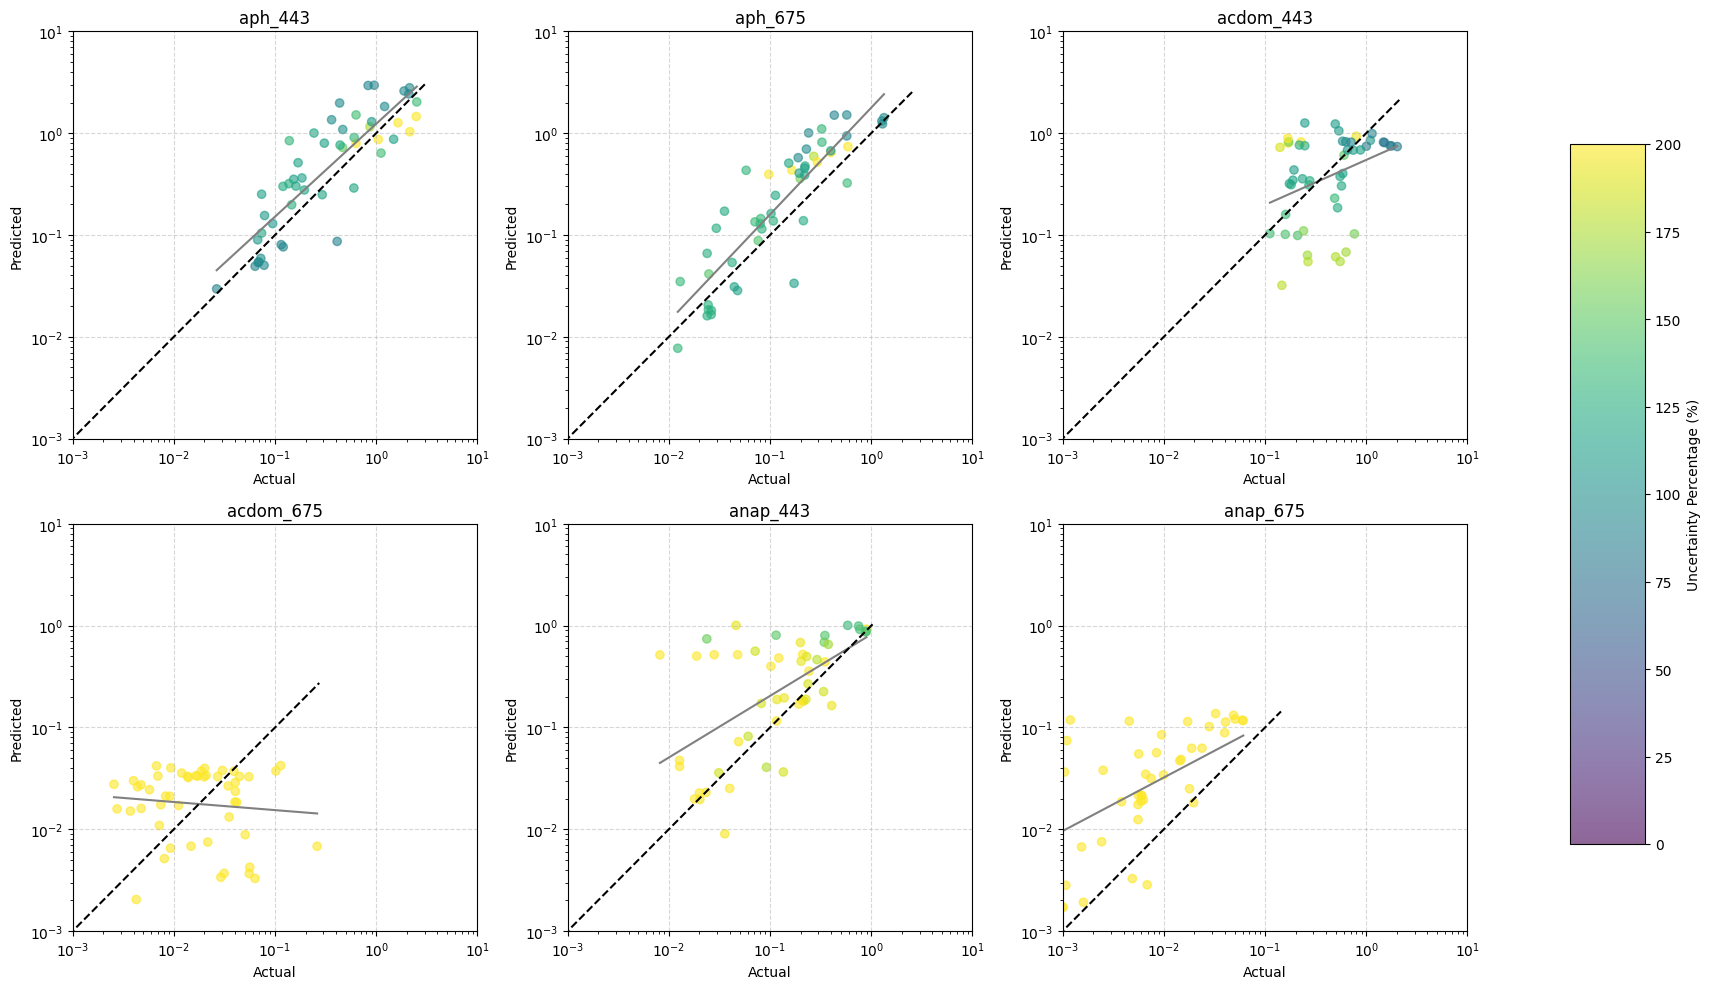

In [90]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Calculate percentage uncertainties relative to the mean predictions
percent_total_uncertainty = (np.sqrt(total_var) / mean_preds) * 100
percent_aleatoric_uncertainty = (np.sqrt(aleatoric_var) / mean_preds) * 100
percent_epistemic_uncertainty = (np.sqrt(epistemic_var) / mean_preds) * 100

# Create subplots: 2 rows, 3 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the array of axes for easy iterating
axs = axs.flatten()

# Apply the mask for values greater than 10^-4
mask = (c3_l2_y_test > 1e-4) & (mean_preds > 1e-4)

# Normalize the uncertainty values for the colormap within the range [0, 300]
norm = plt.Normalize(vmin=0, vmax=200)

# Titles for the subplots
titles = ['aph_443', 'aph_675', 'acdom_443', 'acdom_675', 'anap_443', 'anap_675']

for i, ax in enumerate(axs):
    # Apply the mask to both x and y values
    x_values = c2_l2_y_test[:, i][mask[:, i]]
    y_values = mean_preds[:, i][mask[:, i]]
    color_values = percent_total_uncertainty[:, i][mask[:, i]]  # Use the corresponding uncertainties

    # Scatter plot for actual vs. predicted, colored by total uncertainty
    sc = ax.scatter(x_values, y_values, c=color_values, cmap='viridis', norm=norm, alpha=0.6)
    # Linear regression in log-space
    slope, intercept, r_value, p_value, std_err = linregress(np.log(x_values), np.log(y_values))
    x_reg = np.linspace(min(x_values), max(x_values), 500)
    y_reg = np.exp(intercept + slope*np.log(x_reg))
    ax.plot(x_reg, y_reg, color='grey', label=f'Regression (R²={r_value**2:.2f})')

    # 1:1 Line
    limits = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(limits, limits, ls='--', color='black')


    ax.set_title(titles[i])
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-3, 10)
    ax.set_ylim(1e-3, 10)
    ax.grid(True, ls='--', alpha=0.5)

# Adjust layout to prevent overlap
plt.tight_layout()

# Add a single colorbar to the right of the subplots
cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])  # Position for the colorbar
cbar = plt.colorbar(mappable=sc, cax=cbar_ax, orientation='vertical', norm=norm)
cbar.set_label('Uncertainty Percentage (%)')

# Show plot
plt.show()


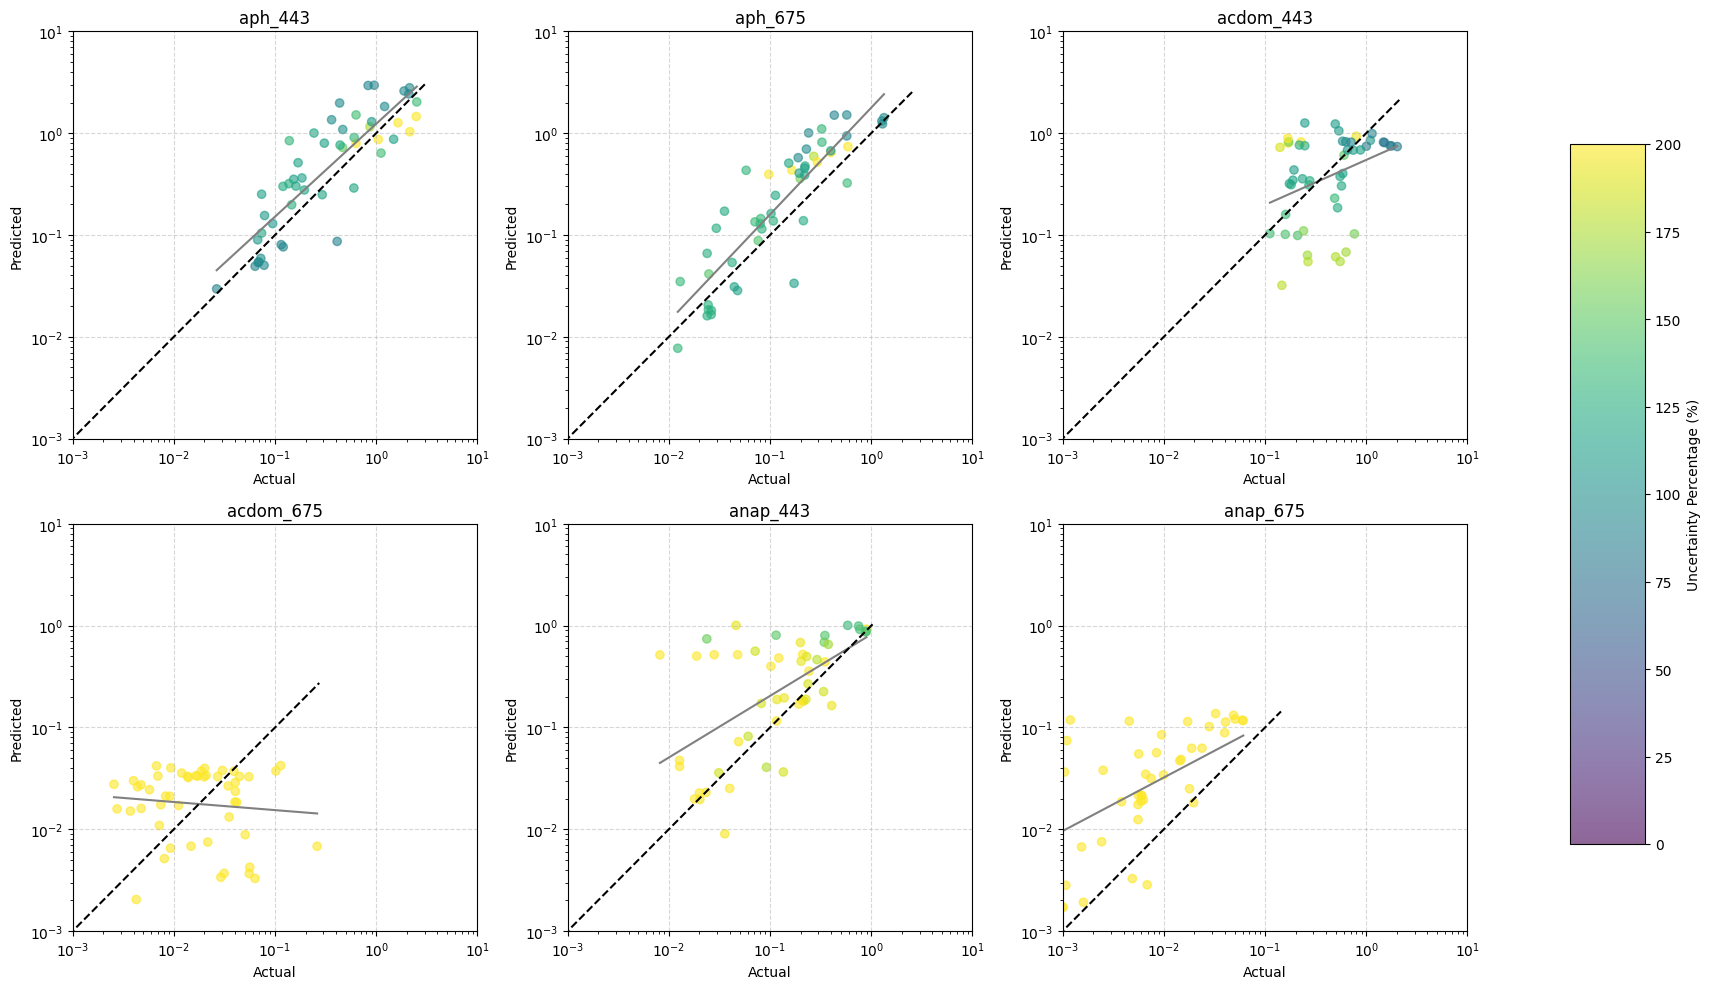

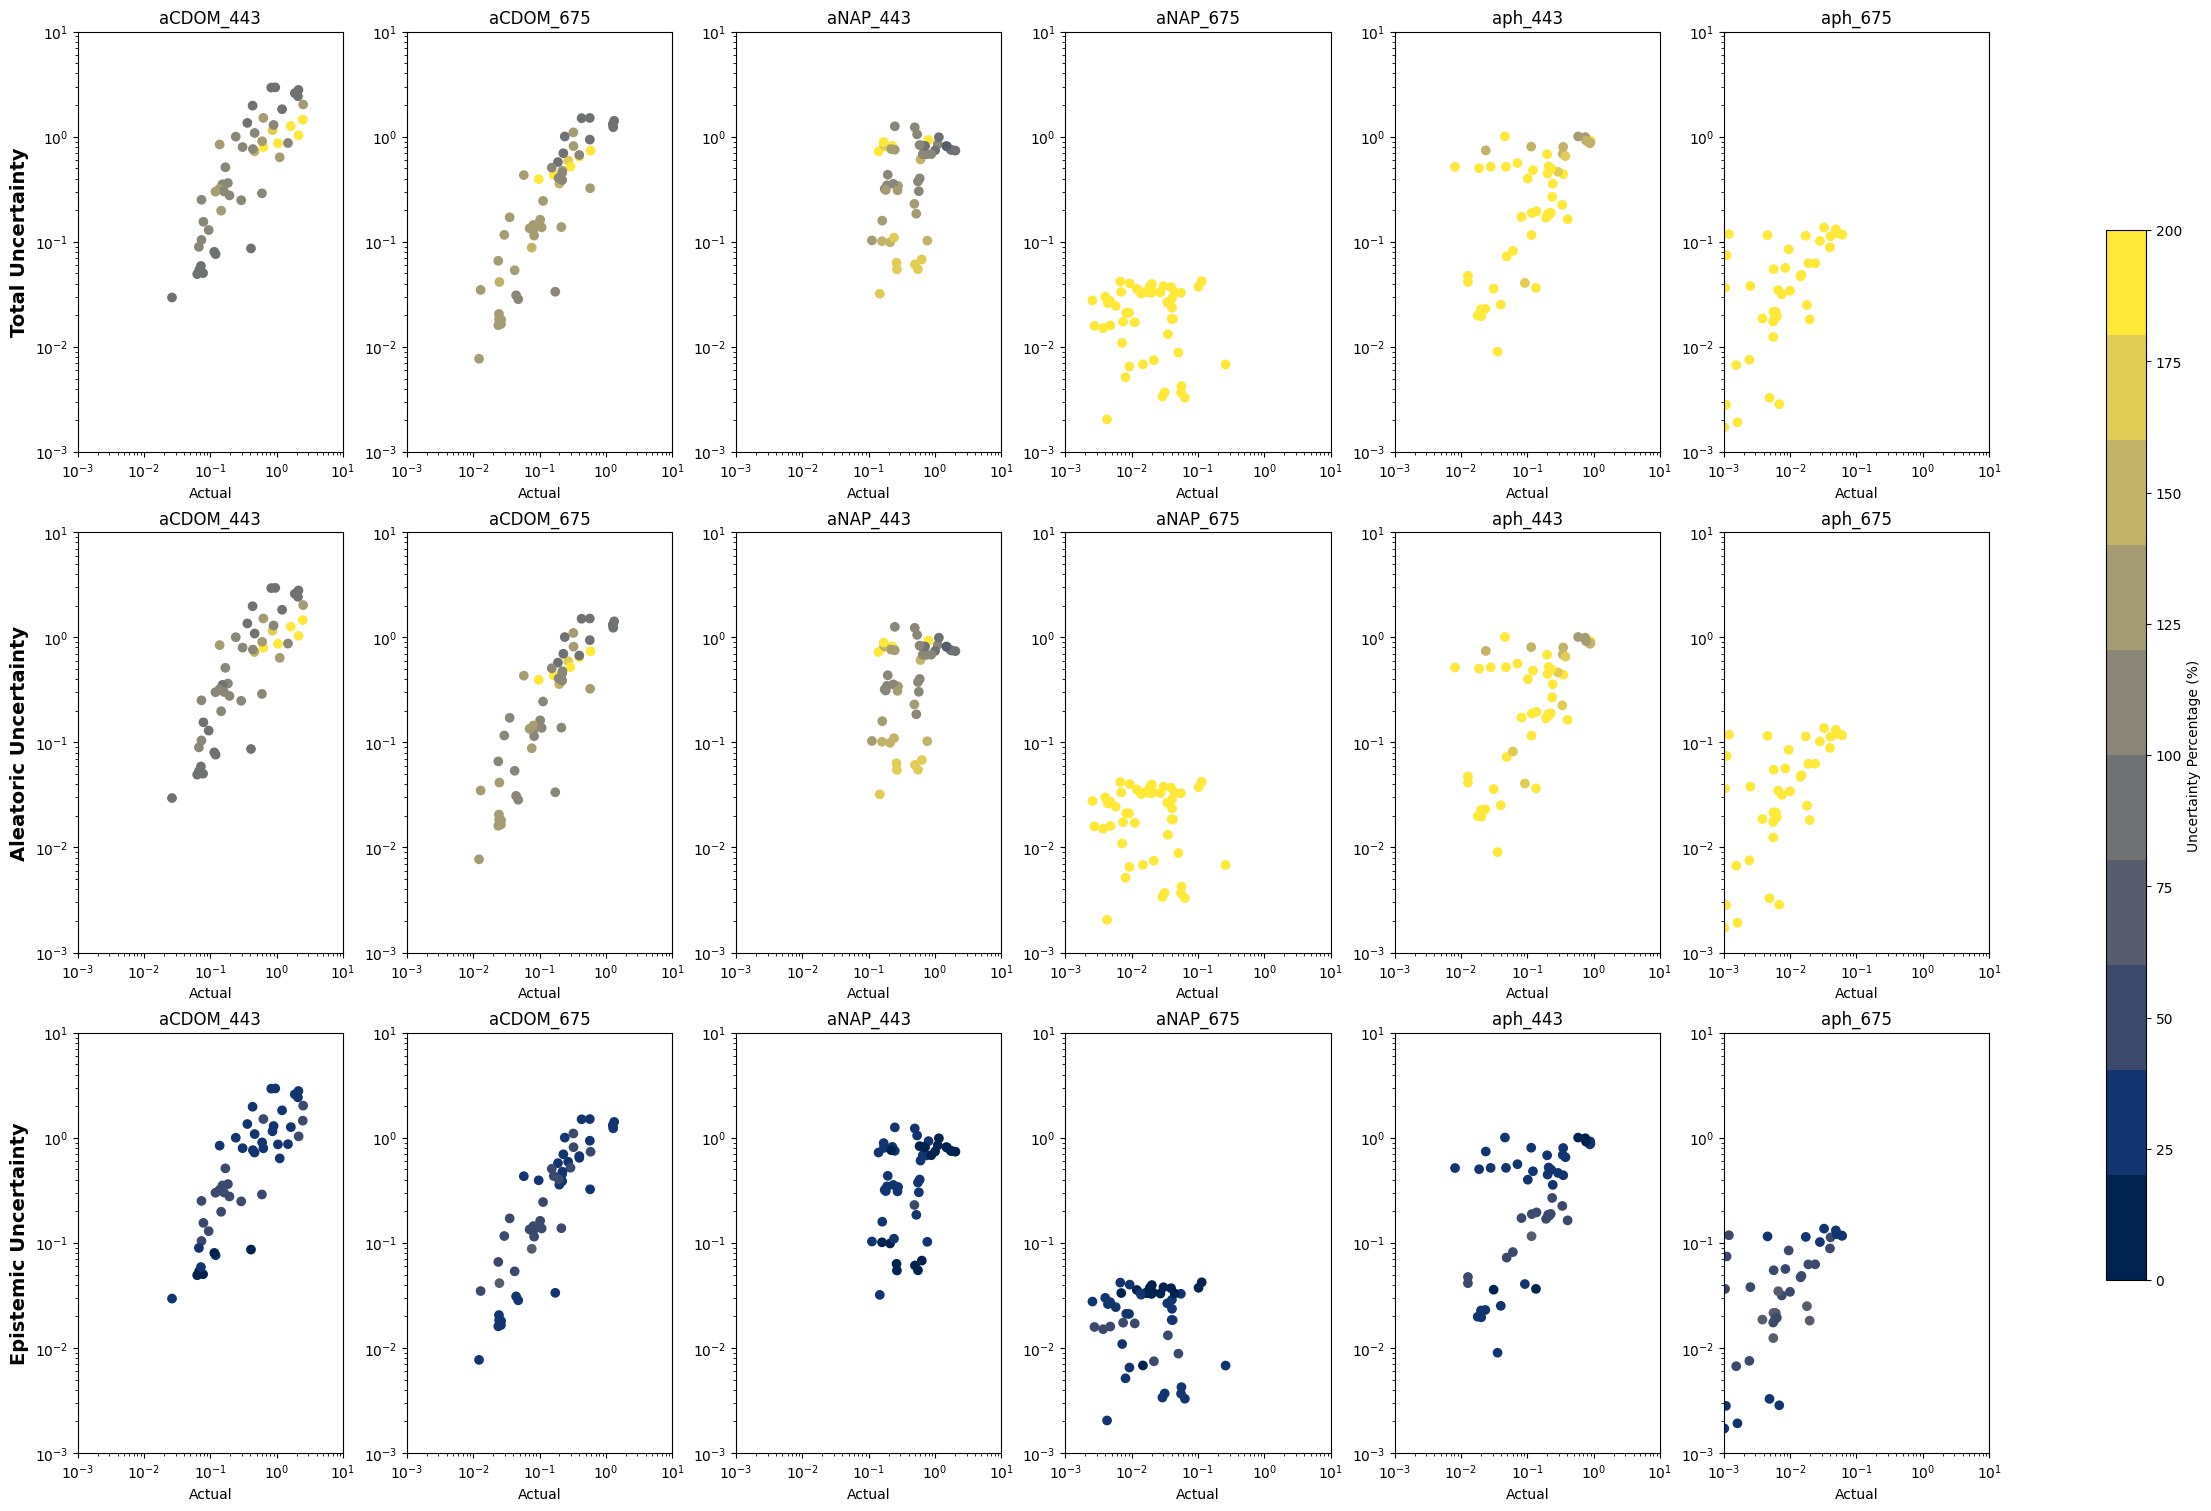

In [91]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Calculate percentage uncertainties relative to the mean predictions
percent_total_uncertainty = (np.sqrt(total_var) / mean_preds) * 100
percent_aleatoric_uncertainty = (np.sqrt(aleatoric_var) / mean_preds) * 100
percent_epistemic_uncertainty = (np.sqrt(epistemic_var) / mean_preds) * 100

# Create subplots: 2 rows, 3 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the array of axes for easy iterating
axs = axs.flatten()

# Apply the mask for values greater than 10^-4
mask = (c3_l2_y_test > 1e-4) & (mean_preds > 1e-4)

# Normalize the uncertainty values for the colormap within the range [0, 300]
norm = plt.Normalize(vmin=0, vmax=200)

# Titles for the subplots
titles = ['aph_443', 'aph_675', 'acdom_443', 'acdom_675', 'anap_443', 'anap_675']

for i, ax in enumerate(axs):
    # Apply the mask to both x and y values
    x_values = c3_l2_y_test[:, i][mask[:, i]]
    y_values = mean_preds[:, i][mask[:, i]]
    color_values = percent_total_uncertainty[:, i][mask[:, i]]  # Use the corresponding uncertainties

    # Scatter plot for actual vs. predicted, colored by total uncertainty
    sc = ax.scatter(x_values, y_values, c=color_values, cmap='viridis', norm=norm, alpha=0.6)
    # Linear regression in log-space
    slope, intercept, r_value, p_value, std_err = linregress(np.log(x_values), np.log(y_values))
    x_reg = np.linspace(min(x_values), max(x_values), 500)
    y_reg = np.exp(intercept + slope*np.log(x_reg))
    ax.plot(x_reg, y_reg, color='grey', label=f'Regression (R²={r_value**2:.2f})')

    # 1:1 Line
    limits = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(limits, limits, ls='--', color='black')


    ax.set_title(titles[i])
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-3, 10)
    ax.set_ylim(1e-3, 10)
    ax.grid(True, ls='--', alpha=0.5)

# Adjust layout to prevent overlap
plt.tight_layout()

# Add a single colorbar to the right of the subplots
cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])  # Position for the colorbar
cbar = plt.colorbar(mappable=sc, cax=cbar_ax, orientation='vertical', norm=norm)
cbar.set_label('Uncertainty Percentage (%)')

# Show plot
plt.show()

# Titles for the subplots
titles = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']
uncertainty_labels = ['Total Uncertainty', 'Aleatoric Uncertainty', 'Epistemic Uncertainty']

# Create a 3x6 subplot grid for each type of uncertainty and each variable
fig, axs = plt.subplots(3, 6, figsize=(20, 15), constrained_layout=True)

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Normalize the uncertainty values for the colormap within the range [0, 200]
norm = plt.Normalize(vmin=0, vmax=200)

# Function to create a discrete colormap
def create_discrete_colormap(cmap_name, num_bins=10):
    cmap = plt.get_cmap(cmap_name, num_bins)
    return cmap

# Create a discrete colormap with 'cividis'
cmap = create_discrete_colormap('cividis')

# Function to apply the mask and plot the data
def plot_uncertainty(ax, x_values, y_values, uncertainties, title, xlabel, ylabel=None):
    sc = ax.scatter(x_values, y_values, c=uncertainties, cmap=cmap, norm=norm, alpha=1)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel, fontweight='bold', fontsize=14)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-3, 10)
    ax.set_ylim(1e-3, 10)
    return sc

# Apply the mask for values greater than 10^-4
mask = (c2_aco_y_test > 1e-4) & (mean_preds > 1e-4)

# Iterate over each uncertainty type
for i, uncertainty_label in enumerate(uncertainty_labels):
    # Select the appropriate uncertainty
    if uncertainty_label == 'Total Uncertainty':
        uncertainties = percent_total_uncertainty
    elif uncertainty_label == 'Aleatoric Uncertainty':
        uncertainties = percent_aleatoric_uncertainty
    else:  # 'Epistemic Uncertainty'
        uncertainties = percent_epistemic_uncertainty

    # Iterate over each variable
    for j, title in enumerate(titles):
        # Calculate the index for the current subplot
        index = i * 6 + j
        # Apply the mask to both x and y values
        x_values = c2_aco_y_test[:, j][mask[:, j]]
        y_values = mean_preds[:, j][mask[:, j]]
        unc_values = uncertainties[:, j][mask[:, j]]
        # Plot the scatter plot for the current variable and uncertainty type
        ylabel = uncertainty_label if j == 0 else None
        sc = plot_uncertainty(axs[index], x_values, y_values, unc_values, title, 'Actual', ylabel)

# Add a colorbar to the right of the subplots
cbar_ax = fig.add_axes([1.05, 0.15, 0.02, 0.7])  # x, y, width, height
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label('Uncertainty Percentage (%)')

plt.show()


In [92]:
from joblib import load

# Combining all arrays into a single array for easier manipulation
all_data = np.vstack([
    c3_l2_y_test,
    mean_preds,
    total_var,
    aleatoric_var,
    epistemic_var,
    std_preds
    # percent_total_uncertainty = (total_uncertainty / mean_predictions) * 100
    # percent_aleatoric_uncertainty = (aleatoric_uncertainty / mean_predictions) * 100
    # percent_epistemic_uncertainty = (epistemic_uncertainty / mean_predictions) * 100

])

# build the dict
indices = ['y_true', 'y_pred', 'total_var', 'ale_var', 'epi_var', 'std_dev']

# generate df, y_columns defined above
final_df_corrected = pd.DataFrame(all_data, columns=c3_y_columns_test)

# assign the provided indices to groups of rows
final_df_corrected.index = np.repeat(indices, [50, 50, 50, 50, 50, 50])

final_df_corrected

# generating a MultiIndex for the DataFrame
multi_index_corrected = pd.MultiIndex.from_product([indices, range(50)], names=['Category', 'Instance'])

# since all_data already combines everything correctly, simply apply the correct MultiIndex to the DataFrame
final_df_multi_indexed_corrected = pd.DataFrame(all_data, index=multi_index_corrected, columns=c3_y_columns_test)

final_df_multi_indexed_corrected

#save
file_path = 'C:/SwitchDrive/Data/prisma_results/case_3/outputs/c3_bnn_dc_l2_preds.csv'
final_df_multi_indexed_corrected.to_csv(file_path)


In [93]:
metrics_df

obs_cor         MAPD       MAD        sspb        mdsa
aph_443         50    93.503325  0.853495   37.387776   56.838166
aph_675         50   116.031601  1.022919   72.265082   78.013875
acdom_443       50    97.241846  1.268925   -8.725280   92.120480
acdom_675       50   161.709602  2.122325   37.895190  138.620536
anap_443        50   418.835348  1.464010   44.355360   66.230032
anap_675        50  1689.454772  4.218043  230.182576  238.029819

# Case 3: In situ combined vs ACO

In [18]:
c3_aco_best_model, c3_aco_best_model_index, c3_aco_mdsa_df= train_and_evaluate_models(c3_X_train_scaled, c3_y_train_scaled, c3_aco_X_test_scaled, c3_aco_y_test, c3_y_columns_test, scaler_y=c3_scaler_y, input_shape = (c3_X_train_scaled.shape[1],), num_models=10)


Epoch 1/1000


C:\Users\werthemo\AppData\Local\Temp\ipykernel_29772\1696363033.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9078 - val_loss: 0.5295
Epoch 2/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5489 - val_loss: 0.2877
Epoch 3/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3800 - val_loss: 0.1497
Epoch 4/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1541 - val_loss: 0.0710
Epoch 5/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0712 - val_loss: -0.1326
Epoch 6/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.0167 - val_loss: -0.2748
Epoch 7/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.1621 - val_loss: -0.3291
Epoch 8/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.2050 - val_loss: -0.1762
Epoch 9/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.2178 - val_loss: -0.4038
Epoch 10/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.2700 - val_loss: -0.4624
Epoch 11/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.3219 - val_loss: -0.4589
Epoch 12/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

C:\Users\werthemo\AppData\Local\Temp\ipykernel_29772\1696363033.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8399 - val_loss: 0.5678
Epoch 2/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4519 - val_loss: 1.4285
Epoch 3/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2877 - val_loss: 0.4139
Epoch 4/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2434 - val_loss: 0.2449
Epoch 5/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2473 - val_loss: -0.0611
Epoch 6/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.0145 - val_loss: -0.2528
Epoch 7/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.1589 - val_loss: -0.3147
Epoch 8/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.1820 - val_loss: -0.1971
Epoch 9/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.2114 - val_loss: -0.3561
Epoch 10/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.2922 - val_loss: -0.4373
Epoch 11/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.2909 - val_loss: -0.3852
Epoch 12/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

C:\Users\werthemo\AppData\Local\Temp\ipykernel_29772\1696363033.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8854 - val_loss: 0.7314
Epoch 2/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6227 - val_loss: 0.3414
Epoch 3/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3226 - val_loss: 0.2361
Epoch 4/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3778 - val_loss: 0.1883
Epoch 5/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2870 - val_loss: 0.0212
Epoch 6/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1249 - val_loss: -0.1073
Epoch 7/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0360 - val_loss: 0.3070
Epoch 8/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3103 - val_loss: 0.0420
Epoch 9/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0805 - val_loss: -0.1715
Epoch 10/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.1620 - val_loss: -0.2667
Epoch 11/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.1776 - val_loss: -0.2189
Epoch 12/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss

C:\Users\werthemo\AppData\Local\Temp\ipykernel_29772\1696363033.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8479 - val_loss: 0.3476
Epoch 2/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4954 - val_loss: 0.4266
Epoch 3/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3521 - val_loss: 0.0775
Epoch 4/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1497 - val_loss: 0.2384
Epoch 5/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1849 - val_loss: 0.2491
Epoch 6/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1581 - val_loss: -0.1803
Epoch 7/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.1089 - val_loss: -0.2528
Epoch 8/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.1884 - val_loss: -0.3589
Epoch 9/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.1946 - val_loss: -0.3573
Epoch 10/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.2464 - val_loss: -0.3737
Epoch 11/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.2891 - val_loss: -0.4069
Epoch 12/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

C:\Users\werthemo\AppData\Local\Temp\ipykernel_29772\1696363033.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8585 - val_loss: 0.4446
Epoch 2/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1343 - val_loss: 0.1664
Epoch 3/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2975 - val_loss: 0.2515
Epoch 4/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1374 - val_loss: -0.0794
Epoch 5/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2037 - val_loss: 0.1877
Epoch 6/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1543 - val_loss: -0.0990
Epoch 7/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0444 - val_loss: -0.2108
Epoch 8/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.0844 - val_loss: -0.2940
Epoch 9/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.1582 - val_loss: -0.3809
Epoch 10/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.2414 - val_loss: -0.3185
Epoch 11/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.2219 - val_loss: -0.3581
Epoch 12/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

C:\Users\werthemo\AppData\Local\Temp\ipykernel_29772\1696363033.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.9071 - val_loss: 0.6600
Epoch 2/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6351 - val_loss: 0.6187
Epoch 3/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.2539 - val_loss: 0.3964
Epoch 4/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4140 - val_loss: 0.3577
Epoch 5/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3414 - val_loss: 0.3657
Epoch 6/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3903 - val_loss: -0.0088
Epoch 7/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1402 - val_loss: -0.0798
Epoch 8/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1330 - val_loss: -0.0623
Epoch 9/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0363 - val_loss: -0.1394
Epoch 10/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0259 - val_loss: -0.1696
Epoch 11/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.0365 - val_loss: -0.0780
Epoch 12/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - l

C:\Users\werthemo\AppData\Local\Temp\ipykernel_29772\1696363033.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9068 - val_loss: 0.5157
Epoch 2/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5472 - val_loss: 0.2505
Epoch 3/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8597 - val_loss: 0.1232
Epoch 4/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4761 - val_loss: 2.2950e-04
Epoch 5/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0792 - val_loss: -0.1854
Epoch 6/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0226 - val_loss: -0.0883
Epoch 7/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.0745 - val_loss: -0.1994
Epoch 8/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.1192 - val_loss: -0.3236
Epoch 9/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.1933 - val_loss: -0.3213
Epoch 10/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.2019 - val_loss: -0.3088
Epoch 11/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.2363 - val_loss: -0.4091
Epoch 12/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

C:\Users\werthemo\AppData\Local\Temp\ipykernel_29772\1696363033.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8605 - val_loss: 0.5808
Epoch 2/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4629 - val_loss: 0.4064
Epoch 3/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3112 - val_loss: 0.0186
Epoch 4/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0603 - val_loss: -0.1284
Epoch 5/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0953 - val_loss: -0.2133
Epoch 6/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.1592 - val_loss: -0.3043
Epoch 7/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.2195 - val_loss: -0.3361
Epoch 8/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.2718 - val_loss: -0.3246
Epoch 9/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.2801 - val_loss: -0.2945
Epoch 10/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.2710 - val_loss: -0.4648
Epoch 11/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.2959 - val_loss: -0.5075
Epoch 12/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/st

C:\Users\werthemo\AppData\Local\Temp\ipykernel_29772\1696363033.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8378 - val_loss: 0.3775
Epoch 2/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7594 - val_loss: 0.4733
Epoch 3/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4753 - val_loss: 0.1063
Epoch 4/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1420 - val_loss: 0.0564
Epoch 5/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2490 - val_loss: 0.3362
Epoch 6/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3293 - val_loss: 0.0031
Epoch 7/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2430 - val_loss: 0.3696
Epoch 8/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4624 - val_loss: 0.2645
Epoch 9/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2379 - val_loss: -0.0761
Epoch 10/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0711 - val_loss: -0.1475
Epoch 11/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0297 - val_loss: -0.2150
Epoch 12/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 

C:\Users\werthemo\AppData\Local\Temp\ipykernel_29772\1696363033.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.3860 - val_loss: 0.4259
Epoch 2/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9571 - val_loss: 0.3711
Epoch 3/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4752 - val_loss: 0.4090
Epoch 4/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5643 - val_loss: 0.6204
Epoch 5/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4931 - val_loss: 0.2153
Epoch 6/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3773 - val_loss: 0.1311
Epoch 7/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2571 - val_loss: 0.1486
Epoch 8/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1956 - val_loss: 0.0131
Epoch 9/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0827 - val_loss: 0.1932
Epoch 10/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1223 - val_loss: -0.1001
Epoch 11/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0219 - val_loss: -0.1411
Epoch 12/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0

In [19]:
c3_aco_mdsa_df

aph_443     aph_675  acdom_443   acdom_675    anap_443    anap_675
0  65.190863   79.854805  81.069730  151.543225  109.860366  328.628995
1  59.634886   92.207818  99.382006  156.890603  167.462620  502.636293
2  57.855538   65.969978  81.456971  157.333806  129.528939  337.647194
3  54.954274   58.407227  85.857927  133.176216  110.670431  302.958767
4  58.034197   77.342137  88.930691  159.583553   99.518125  269.964186
5  41.289764   37.473877  84.657975  123.693341  113.221184  211.508170
6  69.198791   69.448801  78.130112  141.856530  125.054586  274.152431
7  78.297439   77.965445  71.097035  169.230189  132.407448  359.618624
8  64.547851   74.704633  91.065992  145.364297  137.978202  218.048153
9  88.621326  112.229605  98.531730  156.731014  129.601197  279.505493

In [21]:
file_path = 'C:/SwitchDrive/Data/prisma_results/case_3/case_3_bnn_dc_aco.csv'
c3_aco_mdsa_df.to_csv(file_path, index=False)

import os
folder_path = 'C:/SwitchDrive/Data/prisma_results/case_3/models/'
model_path = os.path.join(folder_path, 'bnn_dc_case_3_aco_best.keras')
# Save the model in the recommended format
c3_aco_best_model.save(model_path)

# Define the path to the saved model
c3_aco_model_path = 'C:/SwitchDrive/Data/prisma_results/case_3/models/bnn_dc_case_3_aco_best.keras'
# Load the model
c3_aco_loaded_model = tf.keras.models.load_model(c3_aco_model_path, custom_objects={'DropConnectDense': DropConnectDense, 'nll_loss': nll_loss})

C:\Users\werthemo\AppData\Local\Temp\ipykernel_29772\1696363033.py:11: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(DropConnectDense, self).__init__(**kwargs)


In [30]:
mean_preds, total_var, aleatoric_var, epistemic_var, std_preds = predict_with_uncertainty(c3_aco_loaded_model, c3_aco_X_test_scaled, c3_scaler_y, n_samples=100)
metrics_df = calculate_and_store_metrics(c3_aco_y_test, mean_preds, c3_y_columns_test)


In [31]:
metrics_df

obs_cor         MAPD       MAD        sspb        mdsa
aph_443         50    67.117433  0.680650   11.887207   38.981049
aph_675         50    68.620857  0.610881    8.878829   38.906071
acdom_443       50    88.354797  1.057009    3.378148   83.821667
acdom_675       50   108.606503  1.917452    8.796898  127.225060
anap_443        50   499.047567  1.831372   91.482211  104.979496
anap_675        50  1298.313996  3.305950  150.813064  161.187887

In [32]:
from joblib import load

# Combining all arrays into a single array for easier manipulation
all_data = np.vstack([
    c3_aco_y_test,
    mean_preds,
    total_var,
    aleatoric_var,
    epistemic_var,
    std_preds
])

# build the dict
indices = ['y_true', 'y_pred', 'total_var', 'ale_var', 'epi_var', 'std_dev']

# generate df, y_columns defined above
final_df_corrected = pd.DataFrame(all_data, columns=c3_y_columns_test)

# assign the provided indices to groups of rows
final_df_corrected.index = np.repeat(indices, [50, 50, 50, 50, 50, 50])

final_df_corrected

# generating a MultiIndex for the DataFrame
multi_index_corrected = pd.MultiIndex.from_product([indices, range(50)], names=['Category', 'Instance'])

# since all_data already combines everything correctly, simply apply the correct MultiIndex to the DataFrame
final_df_multi_indexed_corrected = pd.DataFrame(all_data, index=multi_index_corrected, columns=c3_y_columns_test)

final_df_multi_indexed_corrected

#save
file_path = 'C:/SwitchDrive/Data/prisma_results/case_3/outputs/c3_bnn_dc_aco_preds.csv'
final_df_multi_indexed_corrected.to_csv(file_path)
